In [1]:
import xarray as xr
import pandas as pd

import hvplot.pandas
import hvplot.xarray

from matplotlib import rcParams
rcParams.update({'font.size': 14})
import matplotlib.cm as cm

import seaborn as sns

import pathlib
import re

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, itertools, warnings
warnings.filterwarnings("ignore")

import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [3]:
import holoviews as hv
from bokeh.models.formatters import DatetimeTickFormatter
## Set format for showing x-axis ... you only need days, but in case counts change
formatter = DatetimeTickFormatter(days=["%m-%d"], months=["%m-%d"], years=["%m-%d"])

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')

In [4]:
import CalculateDerates as calc_derates
import transmission as tr
import SAC as SAC

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size']= 12

In [6]:
from datetime import datetime

# Inputs

In [7]:
results_dir = '/glade/work/sriharis/paper2_SAC_data/09102023_CO2cap/'
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'
met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'
#results_dir_dispatch = '/glade/work/sriharis/paper2_SAC_data/07262023/'
results_dir_dispatch = results_dir 
all_regions = {'CAMX':'CAMx', 'Desert_Southwest':'DSW', 'NWPP_Central':'NWPP Central', 'NWPP_NE':'NWPP NE', 'NWPP_NW':'NWPP NW'}
CE_ens = ['r12i1301p1f2', 'r10i1181p1f1', 'r9i1301p1f1', 'r10i1191p1f2', 'r5i1231p1f1']
ens_info = pd.read_csv('ensinfo.csv')
pathway_rename_dict={#'80RE0W0':'80 %', '60RE0W0':'60 %',
                     '40RE0W0':'40 %',
                    #'20RE0W0':'20 %'
                    }                       
                     #'40RE0W15':'40 %, W 15%', '40RE0W25':'40 %, W 25%',
                     #'20RE0W15':'20 %, W 15%', '20RE0W25':'20 %, W 25%'}
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']
month_map = {"%.1f"%(idx+1):val for idx,val in enumerate(months)}

# Analyze timeseries

In [11]:
SAC_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

ENS_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

CO2_allfleets = pd.DataFrame()
opcost_allfleets = pd.DataFrame()

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if pathway not in pathway_rename_dict.keys():
        continue
    
    SAC_fleet = xr.concat([xr.open_mfdataset([results_dir+'/SAC_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+str(year)+'_'+str(i)+'.nc' for year in range(2023,2041)])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    SAC_fleet = SAC_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    SAC_allfleets = xr.merge([SAC_allfleets,SAC_fleet])


In [12]:
SAC_master = SAC_allfleets.copy()

In [14]:
#SAC_master = actual_SAC
SAC_allfleets_yearmin = SAC_master.resample(time='1Y').min()

SAC_min_sumregions_df = SAC_allfleets_yearmin.sel(time='2040').to_dataframe().sum(axis=1)

for idx,region in enumerate(['CAMX']):

    ########
    for idx_yr,year in enumerate(range(2023,2041)):
        print(year)
        d = SAC_allfleets_yearmin.sel(time=str(year))[region]
        #d = SAC_allfleets.sel(time=slice(str(year)+'-06',str(year)+'-09')).min('time')[region]
        SAC_np = d.values.reshape(len(SAC_master.fleet),len(ens_info))
        lim_val = np.max(np.abs(SAC_np))
        
        if region == 'CAMX':
            unique, counts = np.unique(SAC_np.argmin(axis=1), return_counts=True)
            print(unique[np.argmax(counts)],counts[np.argmax(counts)])


2023
44 3
2024
76 5
2025
0 1
2026
88 5
2027
84 4
2028
62 2
2029
50 4
2030
49 2
2031
0 3
2032
24 4
2033
81 3
2034
98 2
2035
35 4
2036
22 4
2037
90 5
2038
1 3
2039
24 3
2040
38 1


# Analyze SAC

In [103]:
cmap_SAC = cm.get_cmap('RdBu', 11)
cmap_regret = cm.get_cmap('Oranges_r', 11)
cmap_timing = cm.get_cmap('twilight_shifted', 12)
cmap_CO2 = cm.get_cmap('RdBu_r', 11)
cmap_opcost = cm.get_cmap('autumn', 11)

In [104]:
SAC_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

ENS_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

CO2_allfleets = pd.DataFrame()
opcost_allfleets = pd.DataFrame()

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if pathway not in pathway_rename_dict.keys():
        continue
    
    SAC_fleet = xr.concat([xr.open_mfdataset([results_dir+'/SAC_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+year+'_'+str(i)+'.nc' for year in ['2030','2040']])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    SAC_fleet = SAC_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    SAC_allfleets = xr.merge([SAC_allfleets,SAC_fleet])

    ENS_fleet = xr.concat([xr.open_mfdataset([results_dir+'/ENS_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+year+'_'+str(i)+'.nc' for year in ['2030','2040']])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    ENS_fleet = ENS_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    ENS_allfleets = xr.merge([ENS_allfleets,ENS_fleet])

    
    co_year = '2040'
    CO2_fleets = pd.concat([pd.read_csv(results_dir+'/CO2_emis_pway'
                                        +pathway+'_invens'+invest_ens
                                        +'_year'+year+'_'+str(i)+'.csv')
                            for i in range(10) for year in [co_year]])
    
    CO2_fleets['year'] = np.repeat(pd.DatetimeIndex([co_year]),100)
    CO2_fleets = CO2_fleets.set_index(['year','ensemble_forcing'])
    CO2_fleets.columns = [pathway_rename_dict[pathway]+', '+invest_ens[:-4]]
    CO2_fleets = CO2_fleets/(pd.read_csv(base_dir+'WECCC'+pathway+'EM'+invest_ens+
                                        '/'+co_year+'/CE/co2CapCE'
                                         +co_year+'.csv',index_col=0).values.sum()\
                             *2000/2)
                 # CO2 cap is specified in tons for 2 years. 
                 #So multiply by 2000 to get lbs and divide by 2 for one year.
    
    CO2_allfleets = pd.concat([CO2_allfleets,CO2_fleets],axis=1)
        
    opcost_fleets = pd.read_csv(results_dir+'/opcost_all_pway'
                                           +pathway+'_invens'+invest_ens
                                           +'.csv',index_col=0).sum(axis=1).to_frame()
                               
    
    opcost_fleets['year'] = np.repeat(pd.DatetimeIndex(['2040']),100)
    opcost_fleets = opcost_fleets.reset_index().set_index(['year','ensemble_forcing'])
    opcost_fleets.columns = [pathway_rename_dict[pathway]+','+invest_ens[:-4]]
    
    opcost_allfleets = pd.concat([opcost_allfleets,opcost_fleets],axis=1)

SAC_allfleets['pathway'] = ('fleet',[val[:4] for val in SAC_allfleets.fleet.values])
SAC_allfleets['invest_ens'] = ('fleet',[val[5:] for val in SAC_allfleets.fleet.values])
SAC_allfleets = SAC_allfleets.set_coords(('pathway','invest_ens'))

ENS_allfleets['pathway'] = ('fleet',[val[:4] for val in ENS_allfleets.fleet.values])
ENS_allfleets['invest_ens'] = ('fleet',[val[5:] for val in ENS_allfleets.fleet.values])
ENS_allfleets = ENS_allfleets.set_coords(('pathway','invest_ens'))

CO2_allfleets = CO2_allfleets.sort_index(axis=1)
opcost_allfleets = opcost_allfleets.sort_index(axis=1)
SAC_master = SAC_allfleets.copy()

In [105]:
(ENS_allfleets.sel(time='2040').sum('time').CAMX.values == 0).sum()/500

0.792

In [30]:
ENS_allfleets.sel(time='2040').sum('time').CAMX.values.sum()*0.5

2867672.2103664847

In [33]:
(np.sort((ENS_allfleets.sel(time='2040').sum('time').CAMX.values).flatten())[::-1].cumsum()<ENS_allfleets.sel(time='2040').sum('time').CAMX.values.sum()*0.5).sum()

17

In [34]:
17/500*100

3.4000000000000004

In [107]:
y_labels = []
idx = 0
for label in SAC_master['fleet'].values:
    #if idx%5 == 2:
    #    y_labels.append(label[:4]+'    '+label[5:])
    #else:
    y_labels.append(label[5:])
        
    idx+=1

CAMX [[38  1]
 [43  1]
 [46  1]
 [64  1]
 [74  1]]
38
[46 43 38 74 64]
Desert_Southwest [[35  1]
 [38  1]
 [74  2]
 [91  1]]
74
[74 91 74 38 35]
NWPP_Central [[ 7  1]
 [43  1]
 [74  3]]
74
[74  7 74 74 43]
NWPP_NE [[38  3]
 [74  1]
 [78  1]]
38
[38 78 38 74 38]
NWPP_NW [[38  1]
 [40  1]
 [74  3]]
74
[74 40 74 74 38]


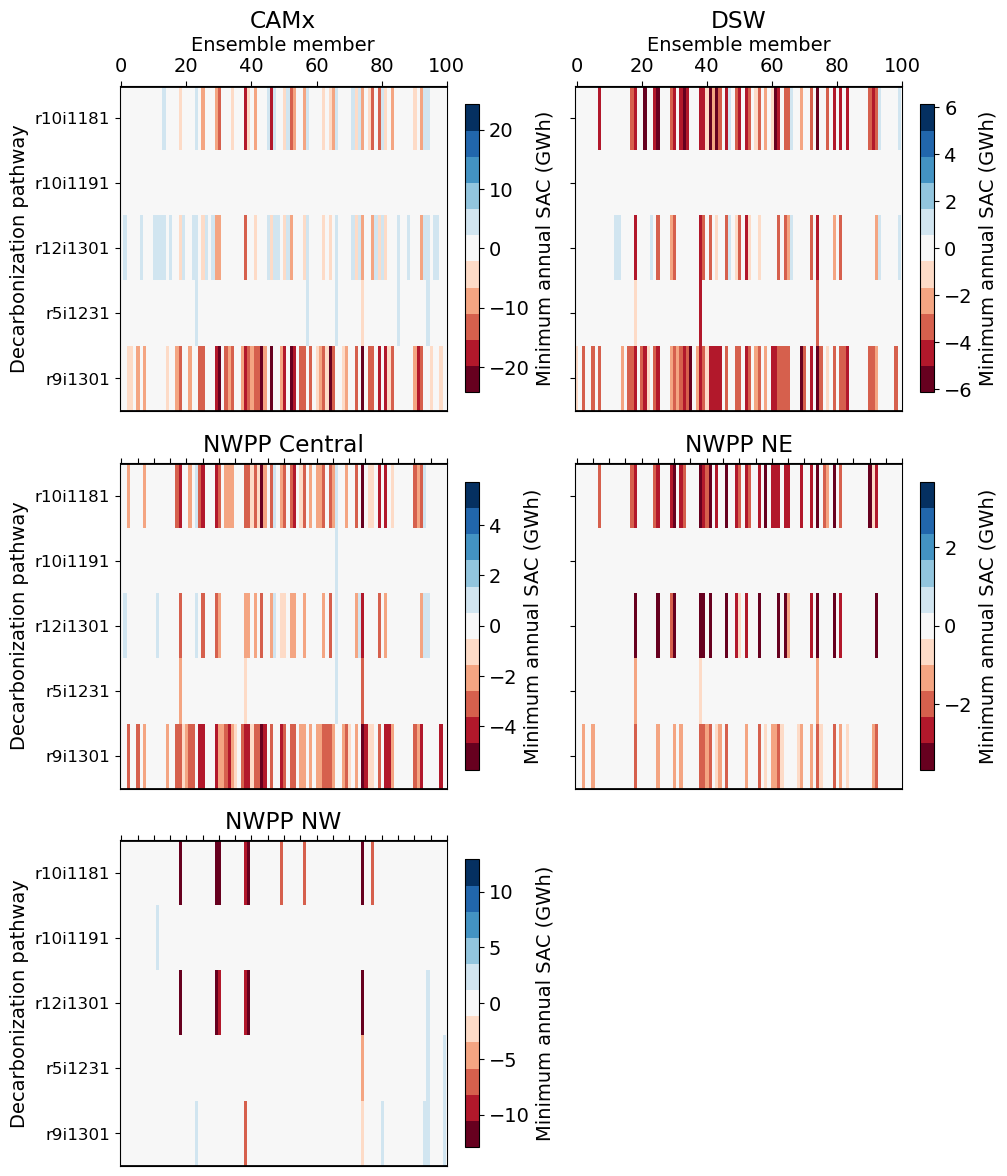

In [132]:
#SAC_master = actual_SAC
SAC_allfleets_yearmin = SAC_master.resample(time='1Y').min()
fig,ax = plt.subplots(3,2,figsize=(10,12))

SAC_min_sumregions_df = SAC_allfleets_yearmin.sel(time='2040').to_dataframe().sum(axis=1)

for idx,region in enumerate(all_regions.keys()):
    row = idx//2
    col = idx%2
    ########
    for idx_yr,year in enumerate(['2040']):
        
        d = SAC_allfleets_yearmin.sel(time=year)[region]
        #d = SAC_allfleets.sel(time=slice(year+'-06',year+'-09')).min('time')[region]
        SAC_np = d.values.reshape(len(SAC_master.fleet),len(ens_info))
        lim_val = np.max(np.abs(SAC_np))
        
    
        unique, counts = np.unique(SAC_np.argmin(axis=1), return_counts=True)
        print(region,np.asarray((unique, counts)).T)
        print(SAC_np.sum(axis=0).argmin())
        print(SAC_np.argmin(axis=1))

        im = ax[row,col].imshow(SAC_np/1e3,aspect=100/len(SAC_master.fleet),
                   cmap=cmap_SAC,
                   vmin=-1*lim_val/1e3,vmax=lim_val/1e3
                  )
        # Minor ticks
        ax[row,col].set_yticks(np.arange(-.5, 5*len(pathway_rename_dict), 5), minor=True)
        ax[row,col].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
        ax[row,col].tick_params(which='minor', bottom=False, left=False)
        
        if row!=0:
            ax[row,col].set_xticks(ticks=np.arange(0, 101, 5),labels=[])
            ax[row,col].xaxis.tick_top()
            ax[row,col].set_title(all_regions[region],y=1.01)
        else:
            ax[row,col].set_title(all_regions[region])

        cbar = fig.colorbar(im,ax=ax[row,col],label='Minimum annual SAC (GWh)',fraction=0.04, pad=0.05,location='right',
                           #format=lambda x, _: int(x/1e3)
                           )        


    ax[row,0].set_ylabel('Decarbonization pathway')
    ax[row,0].set_yticks(ticks=range(len(d['fleet'].values)),
               labels=y_labels,fontsize=12
              )

    ax[row,1].set_yticks(ticks=range(len(d['fleet'].values)),labels=[]) 

ax[0,0].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,0].set_xlabel('Ensemble member')
ax[0,0].xaxis.set_label_position('top') 
ax[0,0].xaxis.tick_top() 

ax[0,1].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,1].set_xlabel('Ensemble member')
ax[0,1].xaxis.set_label_position('top') 
ax[0,1].xaxis.tick_top() 

ax[2,1].remove()

plt.tight_layout()
#plt.savefig('figures/SAC_3regions_allfleets.png')#, bbox_inches='tight')
plt.show()

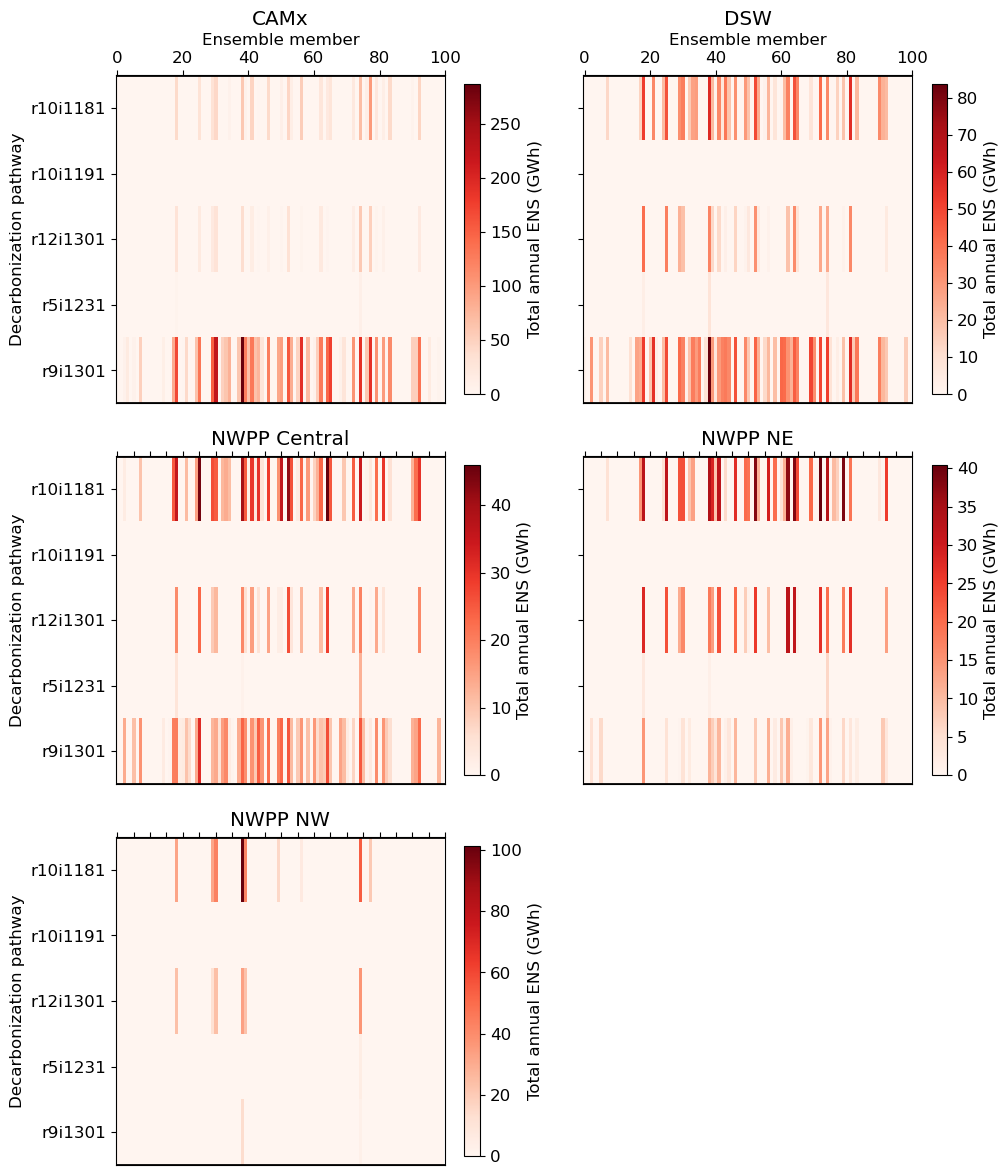

In [29]:
#SAC_master = actual_SAC
ENS_allfleets_yeartot = ENS_allfleets.resample(time='1Y').sum()
fig,ax = plt.subplots(3,2,figsize=(10,12))

SAC_min_sumregions_df = ENS_allfleets_yeartot.sel(time='2040').to_dataframe().sum(axis=1)

for idx,region in enumerate(all_regions.keys()):
    row = idx//2
    col = idx%2
    ########
    for idx_yr,year in enumerate(['2040']):
        d = ENS_allfleets_yeartot.sel(time=year)[region]
        #d = SAC_allfleets.sel(time=slice(year+'-06',year+'-09')).min('time')[region]
        SAC_np = d.values.reshape(len(SAC_master.fleet),len(ens_info))
        lim_val = np.max(np.abs(SAC_np))
        
        #if region == 'CAMX' and year == '2040':
        #    print(SAC_np.argmax(axis=1))

        im = ax[row,col].imshow(SAC_np/1e3,aspect=100/len(SAC_master.fleet),
                   cmap='Reds',
                   vmin=0,vmax=lim_val/1e3
                  )
        # Minor ticks
        ax[row,col].set_yticks(np.arange(-.5, 5*len(pathway_rename_dict), 5), minor=True)
        ax[row,col].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
        ax[row,col].tick_params(which='minor', bottom=False, left=False)

        if row!=0:
            ax[row,col].set_xticks(ticks=np.arange(0, 101, 5),labels=[])
            ax[row,col].xaxis.tick_top()
            ax[row,col].set_title(all_regions[region],y=1.01)
        else:
            ax[row,col].set_title(all_regions[region])

        cbar = fig.colorbar(im,ax=ax[row,col],label='Total annual ENS (GWh)',fraction=0.04, pad=0.05,location='right',
                           #format=lambda x, _: int(x/1e3)
                           )        


    ax[row,0].set_ylabel('Decarbonization pathway')
    ax[row,0].set_yticks(ticks=range(len(d['fleet'].values)),
               labels=y_labels,fontsize=12
              )

    ax[row,1].set_yticks(ticks=range(len(d['fleet'].values)),labels=[]) 

ax[0,0].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,0].set_xlabel('Ensemble member')
ax[0,0].xaxis.set_label_position('top') 
ax[0,0].xaxis.tick_top() 

ax[0,1].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,1].set_xlabel('Ensemble member')
ax[0,1].xaxis.set_label_position('top') 
ax[0,1].xaxis.tick_top() 

ax[2,1].remove()

plt.tight_layout()
#plt.savefig('figures/SAC_3regions_allfleets.png')#, bbox_inches='tight')
plt.show()

In [53]:
opcostperc.max().max()

104.33973884516523

In [54]:
opcostperc.min().min()

94.43497138683249

In [24]:
CO2_allfleets

40 %, r10i1181  40 %, r10i1191  40 %, r12i1301  \
year       ensemble_forcing                                                   
2040-01-01 r1i1001p1f1             1.005295        0.926619        0.965523   
           r2i1021p1f1             1.019123        0.928447        0.981174   
           r3i1041p1f1             1.038922        0.954376        1.018540   
           r4i1061p1f1             1.009550        0.928323        0.967967   
           r5i1081p1f1             1.064564        0.972890        1.058449   
...                                     ...             ...             ...   
           r16i1301p1f2            1.037685        0.954523        1.002948   
           r17i1301p1f2            0.931627        0.852903        0.899155   
           r18i1301p1f2            1.015528        0.941943        0.987144   
           r19i1301p1f2            1.016082        0.932527        0.969569   
           r20i1301p1f2            0.864590        0.776088        0.842391   

                             40 %, r5i1231  40 %, r9i1301  
year       ensemble_forcing                                
2040-01-01 r1i1001p1f1            1.021503       0.982408  
           r2i1021p1f1            1.041854       0.999791  
           r3i1041p1f1            1.062109       1.010797  
           r4i1061p1f1            1.022873       0.986827  
           r5i1081p1f1            1.075811       1.042639  
...                                    ...            ...  
           r16i1301p1f2           1.052731       1.014202  
           r17i1301p1f2           0.953000       0.914624  
           r18i1301p1f2           1.025762       0.989023  
           r19i1301p1f2           1.028779       0.992492  
           r20i1301p1f2           0.878630       0.840574  

[100 rows x 5 columns]

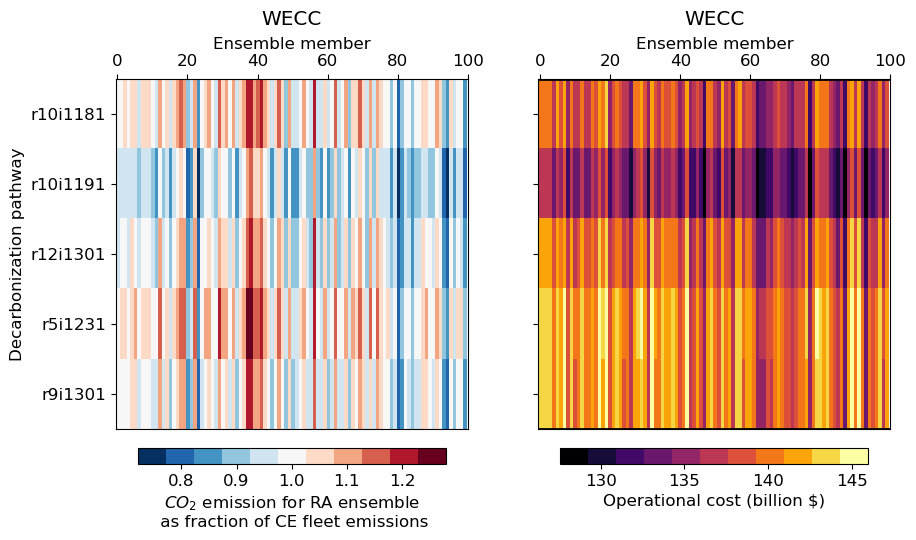

In [31]:
#### CO2 emission
cmap_opcost = cm.get_cmap('inferno', 11)

fig,ax = plt.subplots(1,2,figsize=(10,5))

########
for idx,year in enumerate([co_year]):
    vmin=CO2_allfleets.loc[year].min().min()
    vmax=CO2_allfleets.loc[year].max().max()

    im1 = ax[0].imshow(CO2_allfleets.loc[year].to_numpy().T,
                        cmap=cmap_CO2,aspect=100/len(SAC_allfleets.fleet),
                       #vmin=0.75,vmax=1.25
                        vmin=1-abs(1-(vmin if (1-vmin) > vmax-1 else vmax)),
                        vmax=1+abs(1-(vmin if (1-vmin) > vmax-1 else vmax)),
                       )

    ax[0].set_xticks(ticks=[0,20,40,60,80,100])
    ax[0].set_xlabel('Ensemble member')
    ax[0].xaxis.set_label_position('top') 
    ax[0].xaxis.tick_top() 
    
    # Minor ticks
    ax[0].set_yticks(ticks=range(len(d['fleet'].values)),
               labels=y_labels,fontsize=12
              )
    ax[0].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
    ax[0].tick_params(which='minor', bottom=False, left=False)
    
    ax[0].set_title('WECC',y=1.13)
    
    im2 = ax[1].imshow(opcost_allfleets.to_numpy().T/1e9,
                        cmap=cmap_opcost,
                   aspect=100/len(opcost_allfleets.columns),
                        #vmin=0,
                        #vmax=8,
                       )

    ax[1].set_xticks(ticks=[0,20,40,60,80,100])
    ax[1].set_xlabel('Ensemble member')
    ax[1].xaxis.set_label_position('top') 
    ax[1].xaxis.tick_top() 
    
    # Minor ticks
    ax[1].set_yticks(np.arange(-.5, 5, 5), minor=True)
    ax[1].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
    ax[1].tick_params(which='minor', bottom=False, left=False)
    
    ax[1].set_yticks(ticks=range(len(CO2_allfleets.columns)),labels=[])
    ax[1].set_title('WECC',y=1.13)

ax[0].set_ylabel('Decarbonization pathway')
ax[0].set_yticks(ticks=range(len(CO2_allfleets.columns)),
           labels=y_labels,
          )

cbar_co2 = fig.colorbar(im1,ax=ax[0], label=r'$CO_{2}$'+' emission for RA ensemble\n as fraction of CE fleet emissions',
                fraction=0.04, pad=0.05,
                location='bottom'
               )
cbar = fig.colorbar(im2,ax=ax[1], label='Operational cost (billion $)',
                fraction=0.04, pad=0.05,
                location='bottom'
               )

#fig.text(s=year,x=0.47,y=0.565,fontsize=20)
#plt.tight_layout()
#plt.savefig('figures/CO2emissions_cost.png', bbox_inches='tight')
plt.show()


In [49]:
for col in CO2_allfleets.columns:
    print(col,(CO2_allfleets.loc['2040'][col]>1).sum())

40 %, r10i1181 60
40 %, r10i1191 20
40 %, r12i1301 44
40 %, r5i1231 70
40 %, r9i1301 47


In [38]:
CO2_allfleets.loc['2040'].max().max()

1.2791396259517722

In [40]:
CO2_allfleets.loc['2040'].min().min()

0.27649714401799064

In [47]:
opcost_allfleets.to_numpy().max()

145984963787.03113

In [48]:
opcost_allfleets.to_numpy().min()

127593830588.95609

In [16]:
pathway10_meanCO2 = CO2_allfleets.loc['2040'].iloc[:,0:5].mean(axis=1)
reqd_ens_CO2 = pathway10_meanCO2.loc[pathway10_meanCO2>pathway10_meanCO2.quantile(0.95)].reset_index('ensemble_forcing')['ensemble_forcing']

## Analyze SAC vs met variables

In [11]:
met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'
demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

demand_ds = demand_ds.rename({'member_id':'reliability_ens'})
hydro_ds = hydro_ds.rename({'member_id':'reliability_ens'})

In [12]:
solar_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

wind_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

total_RE_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

flow_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

hydro_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

for year in ['2040']:
    fleet_year = year
    for subdir_name in subdirectories:
        pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))

        pathway = pway_em[0]
        invest_ens = pway_em[1]
    
        if invest_ens == 'r19i1231p1f2':
            continue
    
        if pathway not in pathway_rename_dict.keys():
            continue

        fleet_name = 'WECCC'+pathway+'EM'+invest_ens


        fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

        fleet_year_ds = fleet_ds.sel(time=fleet_year)
        fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
        fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')

        fleet_year_df_solar = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['Solar'])]
        fleet_year_df_solar = fleet_year_df_solar.loc[fleet_year_df_solar['Retired'].isin([False])]

        fleet_year_df_wind = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['Wind'])]
        fleet_year_df_wind = fleet_year_df_wind.loc[fleet_year_df_wind['Retired'].isin([False])]                                                               

        solar_fleet = xr.concat([xr.open_mfdataset(results_dir+'/solar_gen_pway'+pathway+'_invens'+invest_ens 
                                        +'_year'+year+'_'+str(i)+'.nc')
                                 for i in range(10)],
                                dim='reliability_ens'
                               )
        solar_fleet = solar_fleet.expand_dims({#'pathway':[pathway],
                                           #'invest_ens':[invest_ens],
                                           'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                          })
        wind_fleet = xr.concat([xr.open_mfdataset(results_dir+'/wind_gen_pway'+pathway+'_invens'+invest_ens
                                                  +'_year'+year+'_'+str(i)+'.nc')
                                 for i in range(10)],
                                dim='reliability_ens'
                               )
        wind_fleet = wind_fleet.expand_dims({#'pathway':[pathway],
                                           #'invest_ens':[invest_ens],
                                           'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                          })

        flow_fleet = xr.concat([xr.open_mfdataset(results_dir+'flow_gen_pway'+pathway+'_invens'+invest_ens
                                       +'_year'+year+'_'+str(i)+'.nc')
                                 for i in range(10)],
                                dim='reliability_ens'
                               )
        flow_fleet = flow_fleet.expand_dims({#'pathway':[pathway],
                                           #'invest_ens':[invest_ens],
                                           'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                          })


        hydro_fleet = xr.concat([xr.open_mfdataset(results_dir+'hydro_gen_pway'+pathway+'_invens'+invest_ens
                                                   +'_year'+year+'_'+str(i)+'.nc')
                                 for i in range(10)],
                                dim='reliability_ens'
                               )
        hydro_fleet = hydro_fleet.expand_dims({#'pathway':[pathway],
                                           #'invest_ens':[invest_ens],
                                           'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                          })

        total_RE_fleet = solar_fleet+wind_fleet

        for region in all_regions.keys():
            fleet_region_solar = fleet_year_df_solar.loc[fleet_year_df_solar['region'].isin([region])]['Capacity (MW)'].sum()
            fleet_region_wind = fleet_year_df_wind.loc[fleet_year_df_wind['region'].isin([region])]['Capacity (MW)'].sum()

            solar_fleet[region] = solar_fleet[region]/fleet_region_solar
            wind_fleet[region] = wind_fleet[region]/fleet_region_wind
            total_RE_fleet[region] = total_RE_fleet[region]/(fleet_region_solar+fleet_region_wind)

        wind_allfleets = xr.merge([wind_allfleets,wind_fleet])
        solar_allfleets = xr.merge([solar_allfleets,solar_fleet])    
        total_RE_allfleets = xr.merge([total_RE_allfleets,total_RE_fleet])    
        flow_allfleets = xr.merge([flow_allfleets,flow_fleet])    
        hydro_allfleets = xr.merge([hydro_allfleets,hydro_fleet])    

    solar_allfleets['pathway'] = ('fleet',[val[:4] for val in solar_allfleets.fleet.values])
    solar_allfleets['invest_ens'] = ('fleet',[val[5:] for val in solar_allfleets.fleet.values])
    solar_allfleets = solar_allfleets.set_coords(('pathway','invest_ens')) 

    wind_allfleets['pathway'] = ('fleet',[val[:4] for val in wind_allfleets.fleet.values])
    wind_allfleets['invest_ens'] = ('fleet',[val[5:] for val in wind_allfleets.fleet.values])
    wind_allfleets = wind_allfleets.set_coords(('pathway','invest_ens')) 

    total_RE_allfleets['pathway'] = ('fleet',[val[:4] for val in total_RE_allfleets.fleet.values])
    total_RE_allfleets['invest_ens'] = ('fleet',[val[5:] for val in total_RE_allfleets.fleet.values])
    total_RE_allfleets = total_RE_allfleets.set_coords(('pathway','invest_ens'))

    flow_allfleets['pathway'] = ('fleet',[val[:4] for val in flow_allfleets.fleet.values])
    flow_allfleets['invest_ens'] = ('fleet',[val[5:] for val in flow_allfleets.fleet.values])
    flow_allfleets = flow_allfleets.set_coords(('pathway','invest_ens'))

    hydro_allfleets['pathway'] = ('fleet',[val[:4] for val in hydro_allfleets.fleet.values])
    hydro_allfleets['invest_ens'] = ('fleet',[val[5:] for val in hydro_allfleets.fleet.values])
    hydro_allfleets = hydro_allfleets.set_coords(('pathway','invest_ens'))

    SAC_allfleets['pathway'] = ('fleet',[val[:4] for val in SAC_allfleets.fleet.values])
    SAC_allfleets['invest_ens'] = ('fleet',[val[5:] for val in SAC_allfleets.fleet.values])
    SAC_allfleets = SAC_allfleets.set_coords(('pathway','invest_ens')) 
    SAC_allfleets_yearmin = SAC_allfleets.resample(time='1Y').min()
    SAC_allfleets_yeartotal = SAC_allfleets.resample(time='1Y').sum()

    ENS_allfleets['pathway'] = ('fleet',[val[:4] for val in ENS_allfleets.fleet.values])
    ENS_allfleets['invest_ens'] = ('fleet',[val[5:] for val in ENS_allfleets.fleet.values])
    ENS_allfleets = ENS_allfleets.set_coords(('pathway','invest_ens')) 
    ENS_allfleets_yearmin = ENS_allfleets.resample(time='1Y').max()
    ENS_allfleets_yeartotal = ENS_allfleets.resample(time='1Y').sum()


In [50]:
(solar_allfleets.sum('time').compute().where(solar_allfleets.pathway=="20 %",drop=True).to_dataframe().sum(axis=1)/demand_year_total.sum(axis=1)).mean()

0.3391974815245002

In [51]:
(wind_allfleets.sum('time').compute().where(wind_allfleets.pathway=="20 %",drop=True).to_dataframe().sum(axis=1)/demand_year_total.sum(axis=1)).mean()

0.10572909938592887

In [52]:
(hydro_allfleets.sum('time').compute().where(hydro_allfleets.pathway=="20 %",drop=True).to_dataframe().sum(axis=1)/demand_year_total.sum(axis=1)).mean()

0.23374420737546997

In [41]:
demand_year_total.sum(axis=1)

reliability_ens
r10i1181p1f1    3.067003e+07
r10i1191p1f2    3.035713e+07
r10i1231p1f1    3.107623e+07
r10i1251p1f1    3.084310e+07
r10i1281p1f1    3.082263e+07
                    ...     
r9i1171p1f2     3.074848e+07
r9i1231p1f1     3.081322e+07
r9i1251p1f1     3.088148e+07
r9i1281p1f1     3.095808e+07
r9i1301p1f1     3.088237e+07
Length: 100, dtype: float64

In [83]:
demand_ds

<xarray.Dataset>
Dimensions:          (reliability_ens: 100, time: 31391, region: 5)
Coordinates:
  * time             (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2065-12-31
  * region           (region) object 'CAMX' 'Desert_Southwest' ... 'NWPP_NW'
  * reliability_ens  (reliability_ens) object 'r10i1181p1f1' ... 'r9i1171p1f2'
Data variables:
    demand           (reliability_ens, time, region) float64 ...

In [85]:
demand_ds.sel(time='2040').sel(region='CAMX').sum('time')

<xarray.Dataset>
Dimensions:          (reliability_ens: 100)
Coordinates:
    region           <U4 'CAMX'
  * reliability_ens  (reliability_ens) object 'r10i1181p1f1' ... 'r9i1171p1f2'
Data variables:
    demand           (reliability_ens) float64 1.146e+07 1.173e+07 ... 1.158e+07

In [101]:
demand_year_total.sum(axis=1)*24/1e6

reliability_ens
r10i1181p1f1    736.080715
r10i1191p1f2    728.571107
r10i1231p1f1    745.829604
r10i1251p1f1    740.234504
r10i1281p1f1    739.743084
                   ...    
r9i1171p1f2     737.963498
r9i1231p1f1     739.517274
r9i1251p1f1     741.155432
r9i1281p1f1     742.994027
r9i1301p1f1     741.176846
Length: 100, dtype: float64

In [87]:
annual_total_hydro/1e6

region                CAMX  Desert_Southwest  NWPP_Central   NWPP_NE  \
reliability_ens                                                        
r10i1181p1f1     29.665610          8.984198      6.423130  4.008576   
r10i1191p1f2     26.578482          8.770159      5.452946  3.380826   
r10i1231p1f1     28.827436          8.546509      5.366788  3.500646   
r10i1251p1f1     29.253170          9.040275      6.411044  4.956033   
r10i1281p1f1     30.246707          9.048621      6.342485  3.563151   
...                    ...               ...           ...       ...   
r9i1171p1f2      33.117836          8.710505      6.141051  3.911768   
r9i1231p1f1      36.283582          8.977249      7.233388  4.021725   
r9i1251p1f1      36.996262          9.767111      8.563049  4.782142   
r9i1281p1f1      31.199094          9.072688      6.953213  4.003607   
r9i1301p1f1      33.388054          9.068695      6.489603  3.651360   

region              NWPP_NW  
reliability_ens              
r10i1181p1f1     119.426664  
r10i1191p1f2     102.245228  
r10i1231p1f1     103.656636  
r10i1251p1f1     114.623935  
r10i1281p1f1     113.739599  
...                     ...  
r9i1171p1f2      106.637246  
r9i1231p1f1      135.492276  
r9i1251p1f1      161.232511  
r9i1281p1f1      123.259167  
r9i1301p1f1      116.223565  

[100 rows x 5 columns]

In [13]:
demand_year_total = demand_ds.sel(time=year).sum('time').to_dataframe().reset_index(level=1)
demand_year_total = demand_year_total.pivot_table(values='demand',index='reliability_ens', 
                                                    columns='region')

In [14]:
hydro_df = hydro_ds.sel(time=year)\
            .groupby('region').sum().sum('time').to_dataframe().reset_index(level=0)
annual_total_hydro = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

In [ ]:
year = '2040'

for region in all_regions.keys():
    var_dfs = pd.DataFrame()
    for pathway in pathway_rename_dict.values():

        #SAC_pway = SAC_allfleets_yeartotal.sel(time=year)
        SAC_pway = SAC_allfleets_yearmin.sel(time=year)
        SAC_pway = SAC_pway.where(SAC_pway['pathway']==pathway,drop=True)

        #ENS_pway = ENS_allfleets_yeartotal.sel(time=year)
        ENS_pway = ENS_allfleets_yearmin.sel(time=year)
        ENS_pway = ENS_pway.where(ENS_pway['pathway']==pathway,drop=True)

        subset_years = SAC_allfleets.sel(time=year)[region]

        mon_NSEmin_region = xr.concat([subset_years.sel(time=str(year)).idxmin(dim='time').dt.month 
                                       for year in np.unique(subset_years.time.dt.year)],
                                      dim='year')

        mon_NSEmin_region = mon_NSEmin_region.where(mon_NSEmin_region['pathway']==pathway,drop=True)
        
        SAC_min_index = xr.concat([subset_years.sel(time=str(year)).idxmin(dim='time')
                                       for year in np.unique(subset_years.time.dt.year)],
                                      dim='year')

        SAC_min_index = SAC_min_index.where(SAC_min_index['pathway']==pathway,drop=True)

        solar_pway = solar_allfleets.sel(time=year).where(solar_allfleets['pathway']==pathway,drop=True).sel(time=SAC_min_index)

        wind_pway = wind_allfleets.sel(time=year).where(wind_allfleets['pathway']==pathway,drop=True).sel(time=SAC_min_index)

        total_RE_pway = total_RE_allfleets.sel(time=year).where(total_RE_allfleets['pathway']==pathway,drop=True).sel(time=SAC_min_index)
        
        hydro_pway = hydro_allfleets.sel(reliability_ens=SAC_min_index.reliability_ens).sel(time=year).where(hydro_allfleets['pathway']==pathway,drop=True).sel(time=SAC_min_index)
        
        flow_pway = flow_allfleets.sel(reliability_ens=SAC_min_index.reliability_ens).sel(time=year).where(flow_allfleets['pathway']==pathway,drop=True).sel(time=SAC_min_index)

        SAC_pway_df = SAC_pway[region].to_dataframe().reset_index(level='time').rename({region:'SAC'}, axis=1)
        ENS_pway_df = ENS_pway[region].to_dataframe().reset_index(level='time').rename({region:'ENS max'}, axis=1)
        solar_pway_df = solar_pway[region].to_dataframe().reset_index(level='year').rename({region:'Solar'}, axis=1)
        wind_pway_df = wind_pway[region].to_dataframe().reset_index(level='year').rename({region:'Wind'}, axis=1)
        total_RE_pway_df = total_RE_pway[region].to_dataframe().reset_index(level='year').rename({region:'Total RE'}, axis=1)
        SAC_mindate_pway_df = SAC_min_index.to_dataframe().reset_index(level='year').rename({'time':'MinSAC_date'}, axis=1)
        hydro_pway_df = hydro_pway[region].to_dataframe().reset_index(level='year').rename({region:'Hydro'}, axis=1)
        flow_pway_df = flow_pway[region].to_dataframe().reset_index(level='year').rename({region:'Flow total'}, axis=1)
        mon_NSEmin_region_df = mon_NSEmin_region.to_dataframe().reset_index(level='year')

        mon_NSEmin_region_df['month'] = mon_NSEmin_region_df['month'].apply(lambda x:month_map[str(x)])

        #pd.concat([SAC_pway_df,solar_pway_df['Solar'],total_RE_pway_df['Wind']],axis=1)
        df = pd.concat([ENS_pway_df,solar_pway_df['Solar'],wind_pway_df['Wind'],
                        total_RE_pway_df['Total RE'],mon_NSEmin_region_df['month'],
                        SAC_mindate_pway_df['MinSAC_date'],
                        hydro_pway_df['Hydro'],
                        flow_pway_df['Flow total'],
                       ]
                       ,axis=1)

        df['Demand'] = demand_ds.sel(region=region).to_dataframe().loc[df['MinSAC_date'].reset_index().rename({'MinSAC_date':'time'},axis=1)\
                                                                       .set_index(['reliability_ens','time']).index].reset_index('time')['demand'].to_numpy()

        var_dfs = pd.concat([var_dfs,df])

    def return_season(month):
        if month in ['Jun','Jul', 'Aug']:
            return('Summer')
        elif month in ['Sep', 'Oct','Nov']:
            return('Fall')
        elif month in ['Dec','Jan','Feb']:
            return('Winter')
        else:
            return('Spring')

    var_dfs['season'] = var_dfs['month'].apply(return_season)

    var_dfs = var_dfs.reset_index().set_index(['fleet','reliability_ens','invest_ens','pathway','time'])
    
    var_dfs['Demand'] = var_dfs['Demand']/1e3
    var_dfs['Hydro'] = var_dfs['Hydro']/1e3/24
    var_dfs['ENS max'] = var_dfs['ENS max']/1e3

    var_dfs = var_dfs.rename(columns={"Hydro":"HD generation (GWh)",
                            "Demand":"Demand (GWh)",
                            "Solar":"Solar CF",
                            "Wind":"Wind CF",
                            "ENS max":"ENS max (GWh)"}
                  )

    for level in pathway_rename_dict.values():
        g = sns.pairplot(var_dfs.xs(level,level='pathway').xs('2040',level='time')[['ENS max (GWh)','Demand (GWh)',
                                                                                 'Solar CF','Wind CF','HD generation (GWh)',
                                                                                 ]],
                     hue='ENS max (GWh)',#palette=sns.color_palette("hls", 5),
                     corner=True,diag_kws={"linewidth": 0, "shade": False},
                     plot_kws={'alpha':0.5}
                     #hue_order=['Summer','Fall','Winter','Spring']
                    )
    g.fig.suptitle(all_regions[region],fontsize=14,y=0.8)
    plt.savefig('figures/drivers_'+region+'_'+level+'.png')#, bbox_inches='tight')
    #plt.show()

In [ ]:
sns.pairplot(var_dfs.xs('40 %',level='pathway').xs('2040',level='time')[['ENS max','Demand',
                                                                         'Solar','Wind','Hydro',
                                                                         ]],
             #hue='ENS max',palette='Blues',
             corner=True,diag_kws={"linewidth": 0, 
                                   #"shade": False
                                  }
             #hue_order=['Summer','Fall','Winter','Spring']
            )
plt.show()

### Yearly totals

In [37]:
####### Get yearly total solar, wind etc

year = '2040'

for region in ['CAMX']:
    var_dfs = pd.DataFrame()
    for pathway in pathway_rename_dict.values():

        SAC_pway = SAC_allfleets_yeartotal.sel(time=year)
        SAC_pway = SAC_pway.where(SAC_pway['pathway']==pathway,drop=True)

        ENS_pway = ENS_allfleets_yeartotal.sel(time=year)
        ENS_pway = ENS_pway.where(ENS_pway['pathway']==pathway,drop=True)
        
        subset_years = SAC_allfleets.sel(time=year)[region]

        mon_NSEmin_region = xr.concat([subset_years.sel(time=str(year)).idxmin(dim='time').dt.month 
                                       for year in np.unique(subset_years.time.dt.year)],
                                      dim='year')

        mon_NSEmin_region = mon_NSEmin_region.where(mon_NSEmin_region['pathway']==pathway,drop=True)
        
        SAC_min_index = xr.concat([subset_years.sel(time=str(year)).idxmin(dim='time').dt.date 
                                       for year in np.unique(subset_years.time.dt.year)],
                                      dim='year')

        SAC_min_index = SAC_min_index.where(SAC_min_index['pathway']==pathway,drop=True)

        solar_pway = solar_allfleets.sel(time=year).sum('time')/365
        solar_pway = solar_pway.where(solar_pway['pathway']==pathway,drop=True)

        wind_pway = wind_allfleets.sel(time=year).sum('time')/365
        wind_pway = wind_pway.where(wind_pway['pathway']==pathway,drop=True)

        total_RE_pway = total_RE_allfleets.sel(time=year).sum('time')/365
        total_RE_pway = total_RE_pway.where(total_RE_pway['pathway']==pathway,drop=True)

        flow_pway = flow_allfleets.sel(time=year).sum('time')
        flow_pway = flow_pway.where(total_RE_pway['pathway']==pathway,drop=True)

        SAC_pway_df = SAC_pway[region].to_dataframe().reset_index(level=0).rename({region:'SAC'}, axis=1)
        ENS_pway_df = ENS_pway[region].to_dataframe().reset_index(level='time').rename({region:'ENS total'}, axis=1)
        solar_pway_df = solar_pway[region].to_dataframe().rename({region:'Solar'}, axis=1)
        wind_pway_df = wind_pway[region].to_dataframe().rename({region:'Wind'}, axis=1)
        total_RE_pway_df = total_RE_pway[region].to_dataframe().rename({region:'Total RE'}, axis=1)
        flow_pway_df = flow_pway[region].to_dataframe().rename({region:'Flow total'}, axis=1)
        mon_NSEmin_region_df = mon_NSEmin_region.to_dataframe().reset_index(level=0)

        mon_NSEmin_region_df['month'] = mon_NSEmin_region_df['month'].apply(lambda x:month_map[str(x)])

        #pd.concat([SAC_pway_df,solar_pway_df['Solar'],total_RE_pway_df['Wind']],axis=1)
        df = pd.concat([ENS_pway_df,solar_pway_df['Solar'],wind_pway_df['Wind'],
                        #total_RE_pway_df['Total RE'],
                        #flow_pway_df['Flow total']
                       ]
                       ,axis=1)

        df['Demand'] = demand_year_total.loc[df.index.get_level_values(1)][region].to_numpy()
        df['Hydro'] = annual_total_hydro.loc[df.index.get_level_values(1)][region].to_numpy()

        var_dfs = pd.concat([var_dfs,df])
    
    var_dfs = var_dfs.reset_index().set_index(['fleet','reliability_ens','invest_ens','pathway','time'])

#    for level in pathway_rename_dict.values():
#        g = sns.pairplot(var_dfs.xs(level,level='pathway').xs('2040',level='time')[['ENS total','Demand',
#                                                                                 'Solar','Wind','Hydro',
#                                                                                 ]],
#                     hue='ENS total',#palette=sns.color_palette("hls", 5),
#                     corner=True,diag_kws={"linewidth": 0, "shade": False},
#                     plot_kws={'alpha':0.5}
#                     #hue_order=['Summer','Fall','Winter','Spring']
#                    )
#        g.fig.suptitle(region+', '+level,fontsize=14,y=0.8)
#        plt.savefig('figures/total_drivers_'+region+'_'+level+'.png')#, bbox_inches='tight')

In [38]:
var_dfs = var_dfs.reset_index()

var_dfs["Ensemble member"] = "Others"

for ensnum in [38]:
    ens_name = ens_info.loc[ensnum]["ensemble_forcing"]
    var_dfs.loc[var_dfs.reliability_ens.isin([ens_name]),"Ensemble member"] = ens_name[:-4]

    var_dfs = pd.concat([var_dfs.drop(var_dfs[var_dfs.reliability_ens.isin([ens_name])].index,axis=0),
               var_dfs[var_dfs.reliability_ens.isin([ens_name])]])

var_dfs = var_dfs.set_index(['fleet','reliability_ens','invest_ens','pathway','time'])

var_dfs['Demand'] = var_dfs['Demand']/1e6
var_dfs['Hydro'] = var_dfs['Hydro']/1e6/24
var_dfs['ENS total'] = var_dfs['ENS total']/1e6

var_dfs = var_dfs.rename(columns={"Hydro":"HD generation (TWh)",
                        "Demand":"Demand (TWh)",
                        "Solar":"Solar CF",
                        "Wind":"Wind CF",
                        "ENS total":"ENS total (TWh)"}
              )

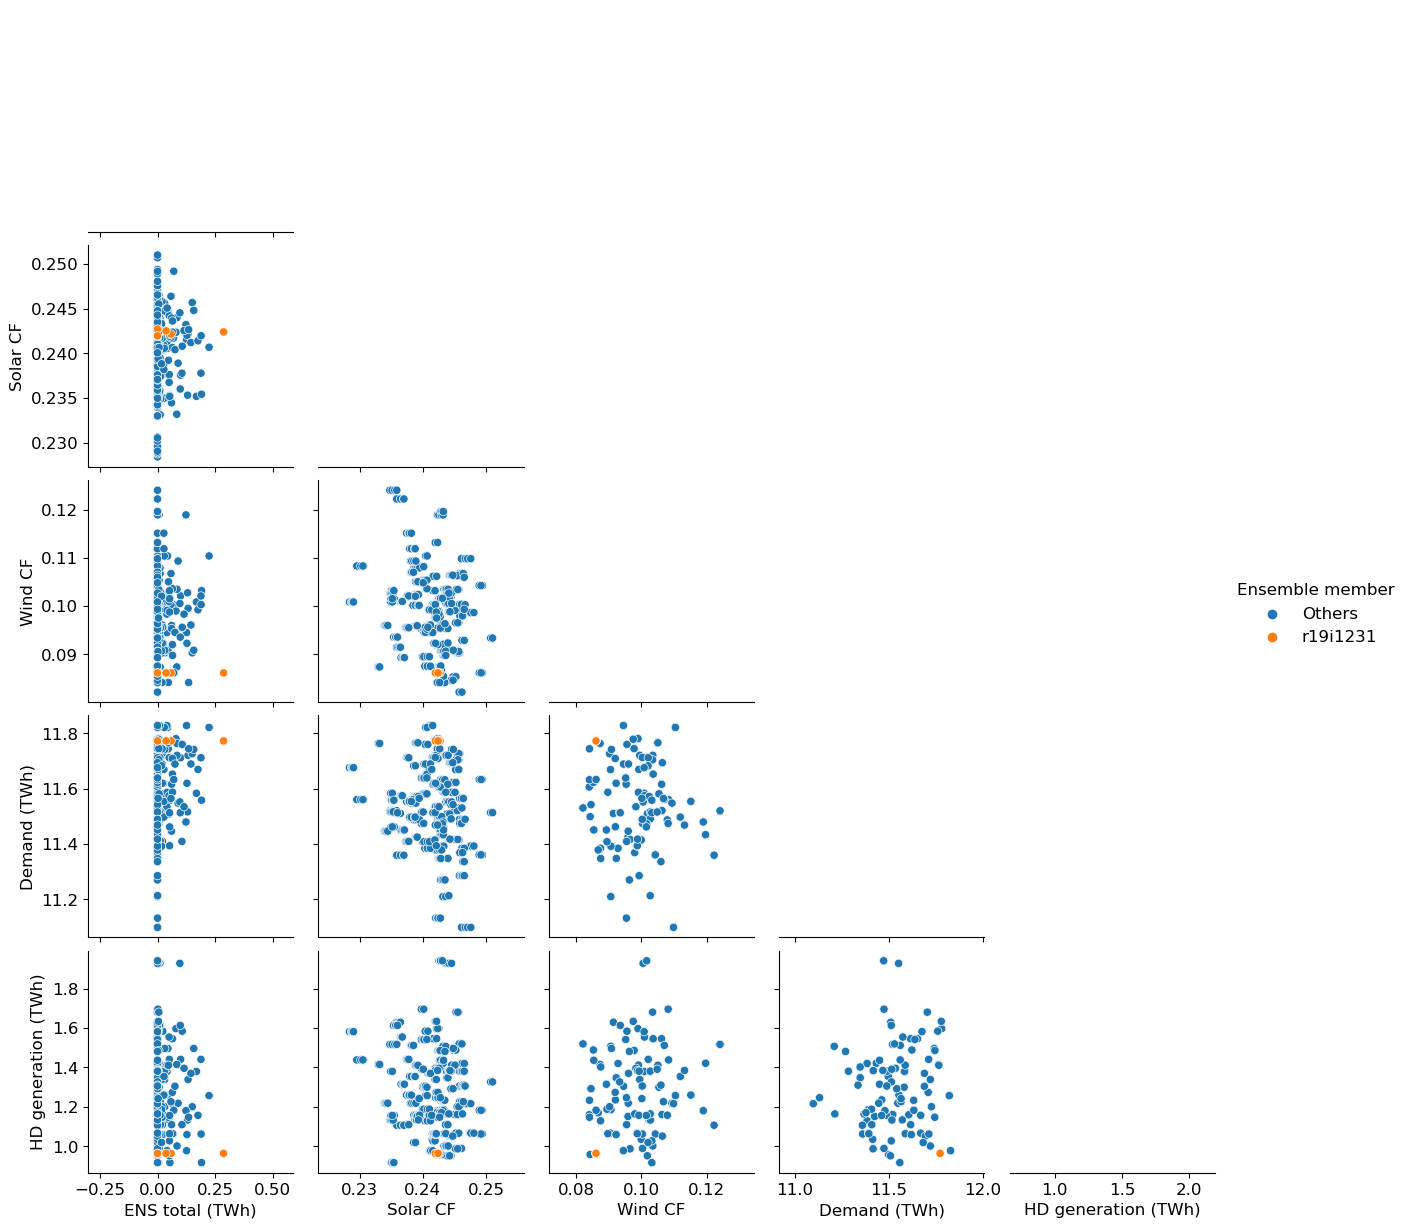

In [39]:
sns.pairplot(var_dfs.xs('2040',level='time'),
             hue='Ensemble member',
             #palette='Blues',
             corner=True,diag_kws={"linewidth": 0, "shade": False}
             #hue_order=['Summer','Fall','Winter','Spring']
            )

plt.show()

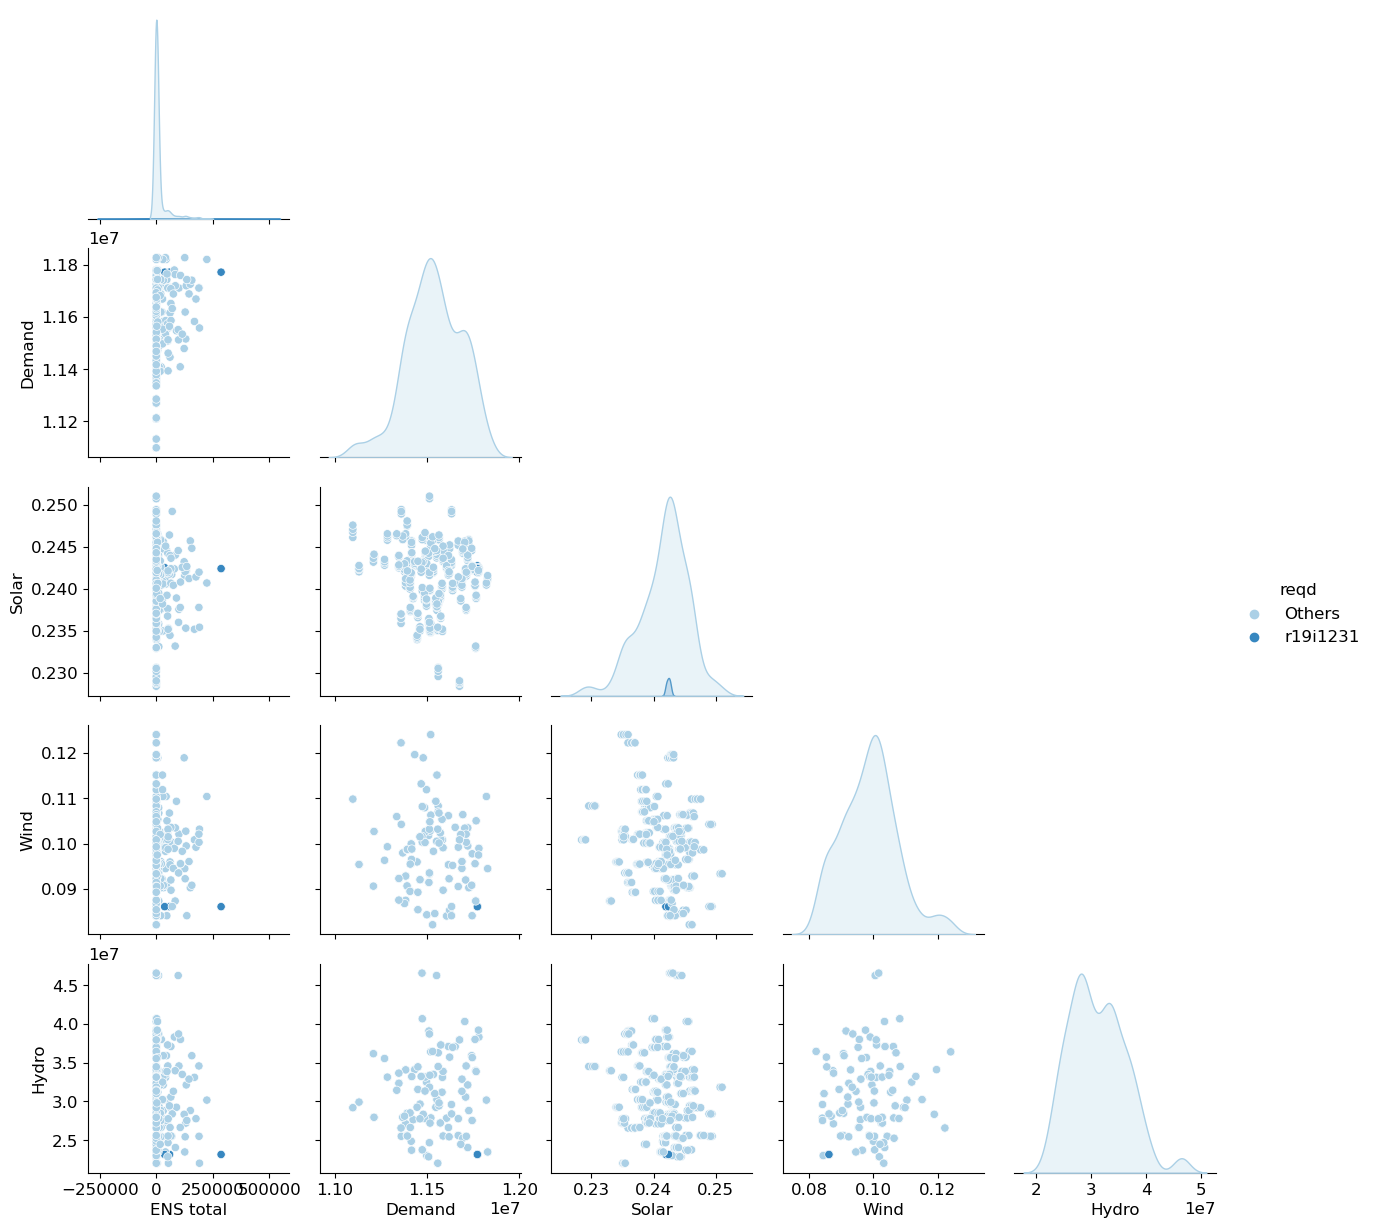

In [66]:
sns.pairplot(var_dfs.xs('40 %',level='pathway').xs('2040',level='time')[['ENS total','Demand',
                                                                         'Solar','Wind','Hydro','reqd'
                                                                         ]],
             hue='reqd',
             palette='Blues',
             corner=True,#diag_kws={"linewidth": 0, "shade": False}
             #hue_order=['Summer','Fall','Winter','Spring']
            )
plt.show()

## Why CO2 like this?

In [15]:
demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

solar_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

wind_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

total_RE_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

flow_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

year = '2040'

if int(year)%2:
    fleet_year = str(int(year)+1)
else:
    fleet_year = year

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))

    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if pathway not in pathway_rename_dict.keys():
        continue
    if invest_ens == 'r19i1231p1f2':
        continue

    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

    fleet_year_ds = fleet_ds.sel(time=fleet_year)
    fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
    fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')

    fleet_year_df_solar = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['Solar'])]
    fleet_year_df_solar = fleet_year_df_solar.loc[fleet_year_df_solar['Retired'].isin([False])]

    fleet_year_df_wind = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['Wind'])]
    fleet_year_df_wind = fleet_year_df_wind.loc[fleet_year_df_wind['Retired'].isin([False])]                                                               

    solar_fleet = xr.concat([xr.open_dataset(results_dir+'/solar_gen_pway'+pathway+'_invens'+invest_ens
                                    +'_year'+year+'_'+str(i)+'.nc') for i in range(10)],
                          dim='reliability_ens'
                           )
    solar_fleet = solar_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+', '+invest_ens[:-4]]
                                      })
    wind_fleet = xr.concat([xr.open_dataset(results_dir+'/wind_gen_pway'+pathway+'_invens'+invest_ens
                                    +'_year'+year+'_'+str(i)+'.nc') for i in range(10)],
                          dim='reliability_ens'
                           )
    wind_fleet = wind_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+', '+invest_ens[:-4]]
                                      })

    total_RE_fleet = solar_fleet+wind_fleet

    fleet_total_solar = fleet_year_df_solar['Capacity (MW)'].sum()
    fleet_total_wind = fleet_year_df_wind['Capacity (MW)'].sum()

    solar_fleet = solar_fleet.to_dataframe().sum(axis=1)/fleet_total_solar
    wind_fleet = wind_fleet.to_dataframe().sum(axis=1)/fleet_total_wind
    total_RE_fleet = total_RE_fleet.to_dataframe().sum(axis=1)/(fleet_total_solar+fleet_total_wind)

    solar_allfleets = xr.merge([solar_allfleets,solar_fleet.to_xarray().rename('Solar')
                               ])    
    wind_allfleets = xr.merge([wind_allfleets,wind_fleet.to_xarray().rename('Wind')
                              ])
    total_RE_allfleets = xr.merge([total_RE_allfleets,total_RE_fleet.to_xarray().rename('Total RE')])    
                                                                           
solar_allfleets['pathway'] = ('fleet',[val[:4] for val in solar_allfleets.fleet.values])
solar_allfleets['invest_ens'] = ('fleet',[val[5:] for val in solar_allfleets.fleet.values])
solar_allfleets = solar_allfleets.set_coords(('pathway','invest_ens')) 

wind_allfleets['pathway'] = ('fleet',[val[:4] for val in wind_allfleets.fleet.values])
wind_allfleets['invest_ens'] = ('fleet',[val[5:] for val in wind_allfleets.fleet.values])
wind_allfleets = wind_allfleets.set_coords(('pathway','invest_ens')) 

total_RE_allfleets['pathway'] = ('fleet',[val[:4] for val in total_RE_allfleets.fleet.values])
total_RE_allfleets['invest_ens'] = ('fleet',[val[5:] for val in total_RE_allfleets.fleet.values])
total_RE_allfleets = total_RE_allfleets.set_coords(('pathway','invest_ens'))

demand_year_total = demand_ds.sel(time=year).sum('time').to_dataframe().reset_index(level=1)
demand_year_total = demand_year_total.pivot_table(values='demand',index='member_id', 
                                                    columns='region').sum(axis=1)

hydro_df = hydro_ds.sel(time=year)\
            .groupby('region').sum().sum('time').to_dataframe().reset_index(level=0)
total_hydro = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region').sum(axis=1)

In [89]:
(non_REgen.loc[gentype_all_df.loc['2040'].loc[gentype_all_df.loc['2040'].PlantType.isin(["CCCCS"])].index.get_level_values('GAMS Symbol')].sum(axis=0)/demand_year_total.sum(axis=1)).mean()

0.16888010091895123

In [19]:
CO2_allfleets_stacked = CO2_allfleets.rename_axis("fleet", axis="columns").loc['2040'].stack().reset_index()
CO2_allfleets_stacked = CO2_allfleets_stacked.rename({'ensemble_forcing':'reliability_ens',0:'Emissions'},axis=1)
CO2_allfleets_stacked = CO2_allfleets_stacked.set_index(['fleet','reliability_ens'])

In [20]:
var_dfs = pd.DataFrame()

for year in ['2040']:
    for pathway in pathway_rename_dict.values():

        solar_pway = solar_allfleets.sel(time=year).mean('time')
        solar_pway = solar_pway.where(solar_pway['pathway']==pathway,drop=True)

        wind_pway = wind_allfleets.sel(time=year).mean('time')
        wind_pway = wind_pway.where(wind_pway['pathway']==pathway,drop=True)

        total_RE_pway = total_RE_allfleets.sel(time=year).mean('time')
        total_RE_pway = total_RE_pway.where(total_RE_pway['pathway']==pathway,drop=True)

        solar_pway_df = solar_pway.to_dataframe()
        wind_pway_df = wind_pway.to_dataframe()
        total_RE_pway_df = total_RE_pway.to_dataframe()

        #pd.concat([SAC_pway_df,solar_pway_df['Solar'],total_RE_pway_df['Wind']],axis=1)
        df = pd.concat([solar_pway_df[['Solar','pathway','invest_ens']],wind_pway_df['Wind'],
                        total_RE_pway_df['Total RE']
                       ]
                       ,axis=1)

        df['Demand'] = demand_year_total.loc[df.index.get_level_values('reliability_ens')].to_numpy()
        df['Hydro'] = total_hydro.loc[df.index.get_level_values('reliability_ens')].to_numpy()

        var_dfs = pd.concat([var_dfs,df])

var_dfs = var_dfs.reset_index()
var_dfs['emission_identifier'] = np.repeat(['low CO2'],len(var_dfs))

#var_dfs.loc[var_dfs['reliability_ens'].isin(reqd_ens_CO2),'emission_identifier'] = 'high CO2'

var_dfs = var_dfs.set_index(['fleet','reliability_ens',])#'invest_ens','pathway'])
var_dfs['Emissions'] = CO2_allfleets_stacked['Emissions']

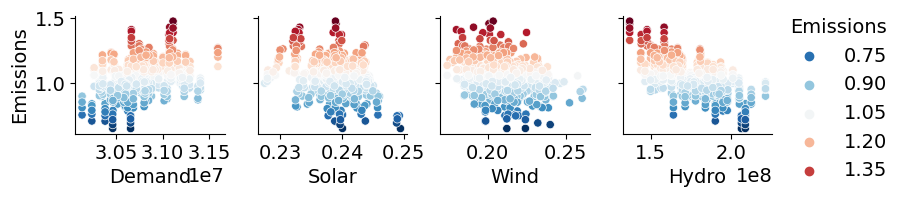

In [125]:
sns.pairplot(var_dfs.loc[var_dfs['pathway'].isin(['20 %'])],
             x_vars=['Demand','Solar','Wind','Hydro'],
             y_vars=['Emissions'],hue='Emissions',palette='RdBu_r',height=2)

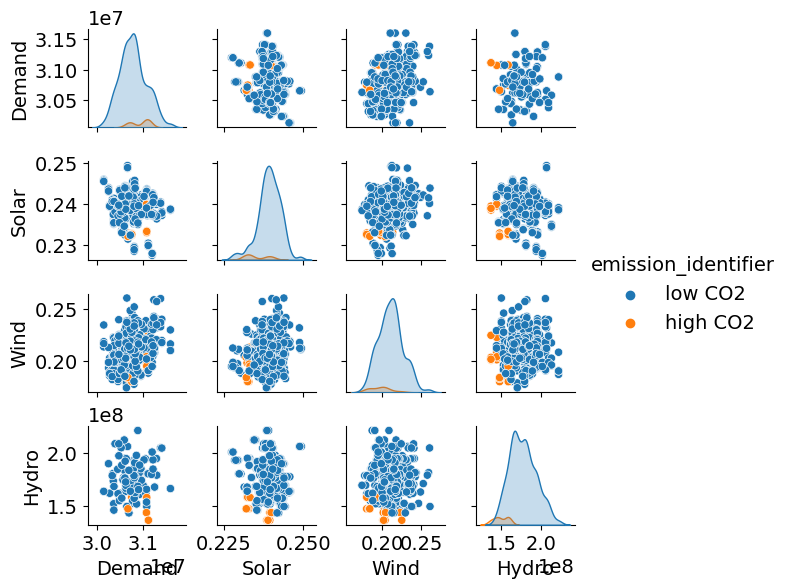

In [126]:
sns.pairplot(var_dfs.loc[var_dfs['pathway'].isin(['20 %'])][['Demand','Solar','Wind','Hydro','emission_identifier']],hue='emission_identifier',height=1.5)

In [21]:
var_dfs['Demand'] = var_dfs['Demand']/1e6
var_dfs['Hydro'] = var_dfs['Hydro']/1e6/24

var_dfs = var_dfs.rename(columns={"Hydro":"HD generation (TWh)",
                        "Demand":"Demand (TWh)",
                        "Solar":"Solar CF",
                        "Wind":"Wind CF",}
              )

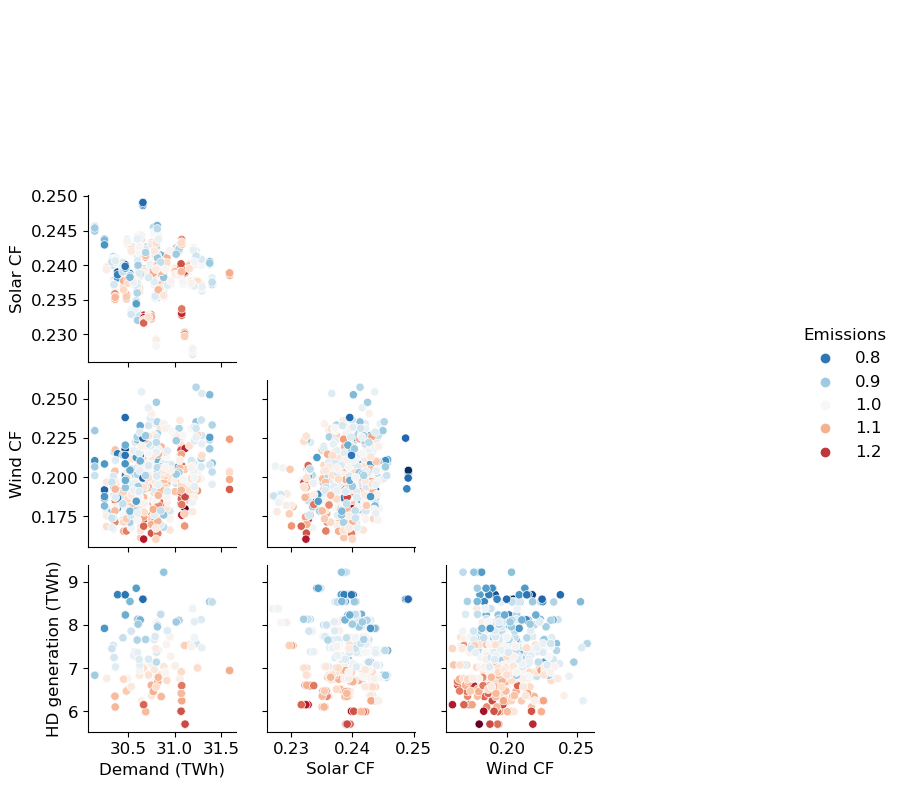

In [22]:
g = sns.pairplot(var_dfs.loc[var_dfs['pathway'].isin(['40 %'])][['Demand (TWh)','Solar CF','Wind CF',
                                                                 'HD generation (TWh)','emission_identifier','Emissions']],
                 hue='Emissions',
                 palette='RdBu_r',height=2,corner=True,diag_kws={"linewidth": 0, "shade": False}
            )

for i, y_var in enumerate(g.y_vars):
    for j, x_var in enumerate(g.x_vars):
        if x_var == y_var:
            g.axes[i, j].set_visible(False)

## Analyze relationship b/w costs and SAC

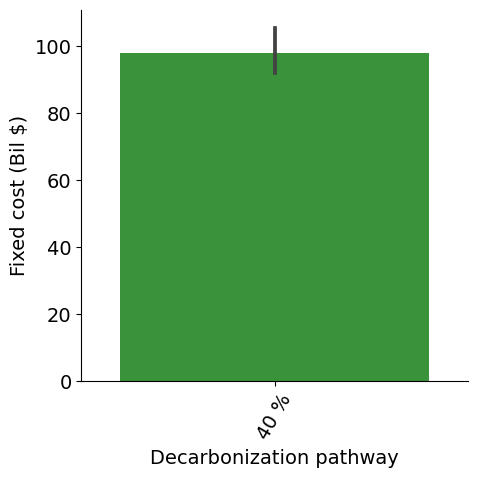

In [109]:
import matplotlib.ticker as ticker

base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

fixed_cost_list = []

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]
year = '2040'

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue

    if pathway not in pathway_rename_dict.keys():
        continue

    fixed_cost = pd.read_csv(results_dir+'fixedcost2040_pway'
                             +pathway+'_invens'+invest_ens+'_year'+year+'.csv',index_col=0).values[0,0]*1e3#/1e9
    
    fixed_cost_list.append([invest_ens,pathway_rename_dict[pathway],fixed_cost])
    
fixed_cost_df = pd.DataFrame(fixed_cost_list,columns=['invest_ens','pathway','Fixed cost (Bil $)'])
fixed_cost_df = fixed_cost_df.sort_values('pathway')
fixed_cost_df['fleet'] = fixed_cost_df['pathway']+','+ fixed_cost_df['invest_ens'].apply(lambda x: x[:-4])

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size']= 14

g = sns.catplot(data=fixed_cost_df.sort_values('pathway',ascending=False),kind='bar',errorbar=('pi',95),
            x='pathway',y='Fixed cost (Bil $)',color='tab:green'
               )

for idx,axes in enumerate(g.axes.flat):
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Decarbonization pathway')
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e9))
    axes.yaxis.set_major_formatter(ticks_y)

plt.tight_layout()
plt.show()

In [110]:
delt_delrh = xr.open_dataset('../capacity_factors/temp_RH_midcentury_diff_WECC_2020to2040diff.nc')
delt_delrh_df = delt_delrh.to_dataframe().reset_index(level=1,drop=True).dropna()

fix_opcost_allfleets_stacked = opcost_allfleets.rename_axis("fleet", axis="columns").stack().reset_index()
fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.rename({'ensemble_forcing':'reliability_ens',0:'Opcost'},axis=1)


fix_opcost_allfleets_stacked['invest_ens'] = [item[5:] for item in fix_opcost_allfleets_stacked['fleet']]
fix_opcost_allfleets_stacked['pathway'] = [item[:4] for item in fix_opcost_allfleets_stacked['fleet']]
#fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.drop('fleet',axis=1)
fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.set_index(['reliability_ens','fleet'])

fix_opcost_allfleets_stacked['Fixcost'] = [fixed_cost_df.loc[fixed_cost_df['fleet'].isin([fleetname])]['Fixed cost (Bil $)'].values[0]
                                                             for fleetname in fix_opcost_allfleets_stacked.index.get_level_values('fleet')] 
fix_opcost_allfleets_stacked['Fixcost'] = fix_opcost_allfleets_stacked['Fixcost']
fix_opcost_allfleets_stacked['delT'] = [delt_delrh_df.loc[ens_id]['TREFHT']
                                        for ens_id in fix_opcost_allfleets_stacked.index.get_level_values('reliability_ens')] 
fix_opcost_allfleets_stacked['delRH'] = [delt_delrh_df.loc[ens_id]['RHREFHT']
                                        for ens_id in fix_opcost_allfleets_stacked.index.get_level_values('reliability_ens')] 

In [111]:
SAC_min_sumregions_df = SAC_allfleets.sel(time='2040').min('time').to_dataframe().sum(axis=1)
SAC_sumregions_df = SAC_allfleets.sel(time='2040').sum('time').to_dataframe().sum(axis=1)

In [112]:
SAC_min_regions_df = SAC_allfleets.sel(time='2040').min('time').to_dataframe()[['CAMX','Desert_Southwest','NWPP_Central','NWPP_NE','NWPP_NW']]

In [113]:
decarb_symbol = {'20 %':'tab:blue', '40 %':'tab:orange', '60 %':'tab:green', '80 %':'tab:red'}
CEens_color = {'r12i1301':'tab:blue', 'r5i1231':'tab:orange','r9i1301':'tab:green', 
               'r10i1181':'tab:red','r10i1191':'tab:purple'}
ens_symbols = ['*','s','^','p']
#,'r19i1231':'tab:cyan'}

In [114]:
reqd_df = fix_opcost_allfleets_stacked.copy()
reqd_df['total_cost'] = fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9
reqd_df['SAC'] = SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index]

reqd_df = reqd_df.groupby('fleet').agg({'total_cost': ['mean', 'min', 'max'],
                              'SAC': ['mean', 'min', 'max']
                             })

In [56]:
reqd_df_regs = fix_opcost_allfleets_stacked.copy()
reqd_df_regs['total_cost'] = fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9
reqd_df_regs = pd.concat([reqd_df_regs,SAC_min_regions_df.loc[fix_opcost_allfleets_stacked.index]],axis=1)

reqd_df_regs = reqd_df_regs.groupby('fleet').agg({'total_cost': ['mean', 'min', 'max'],
                                'CAMX' : ['mean', 'min', 'max'],
                                'Desert_Southwest' : ['mean', 'min', 'max'],
                                'NWPP_Central' : ['mean', 'min', 'max'],
                                'NWPP_NE' : ['mean', 'min', 'max'],
                                'NWPP_NW' : ['mean', 'min', 'max'],
                             })

In [57]:
decarb_color = {'20 %':plt.cm.tab20b(15), '40 %':plt.cm.tab20b(14), '60 %':plt.cm.tab20b(13), '80 %':plt.cm.tab20b(12)}
CEens_color = {'r12i1301':'tab:blue', 'r5i1231':'tab:orange','r9i1301':'tab:green', 
               'r10i1181':'tab:red','r10i1191':'tab:purple','r19i1231':'tab:cyan'}

In [62]:
reqd_df["total_cost"].min().min()

222.95585555944507

In [64]:
reqd_df["total_cost"].max().max()

245.9746960591063

In [97]:
reqd_df

total_cost                                   SAC                \
                     mean         min         max          mean           min   
fleet                                                                           
40 %,r10i1181  229.257519  222.955856  234.251832  -5728.394547 -37373.366581   
40 %,r10i1191  240.399380  233.830609  245.153721    258.494506   -169.003304   
40 %,r12i1301  235.253295  228.663992  240.732479  -1862.845213 -34846.741788   
40 %,r19i1231  250.303859  243.529363  255.165053   9376.092401   2531.513091   
40 %,r5i1231   240.824288  234.207697  245.974696    647.991171 -17616.028406   
40 %,r9i1301   236.310826  229.794674  241.434258 -10213.832871 -37945.650264   

                             
                        max  
fleet                        
40 %,r10i1181   6700.358159  
40 %,r10i1191   2474.061830  
40 %,r12i1301   8231.723051  
40 %,r19i1231  14524.941512  
40 %,r5i1231    5118.235440  
40 %,r9i1301    4172.798660

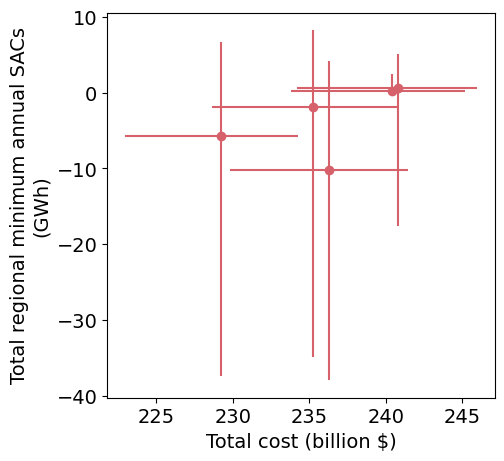

In [58]:
for item in sorted(pathway_rename_dict.values()):
    reqd_df_pway = reqd_df[reqd_df.index.str.startswith(item)]
    plt.errorbar(reqd_df_pway['total_cost']['mean'],
                       reqd_df_pway['SAC']['mean']/1e3,
                       xerr = [reqd_df_pway['total_cost']['mean'] - reqd_df_pway['total_cost']['min'].values,
                               reqd_df_pway['total_cost']['max'].values - reqd_df_pway['total_cost']['mean']],
                       yerr = [reqd_df_pway['SAC']['mean']/1e3 - reqd_df_pway['SAC']['min'].values/1e3,
                               reqd_df_pway['SAC']['max'].values/1e3 - reqd_df_pway['SAC']['mean']/1e3],
                 label=item,
                 fmt="o",
                 zorder=0,
                c=decarb_color[item]
                #cmap=cmap_SAC
               )

#plt.legend(title='Decarb. target', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (billion $)')
plt.ylabel('Total regional minimum annual SACs\n(GWh)')
plt.show()            

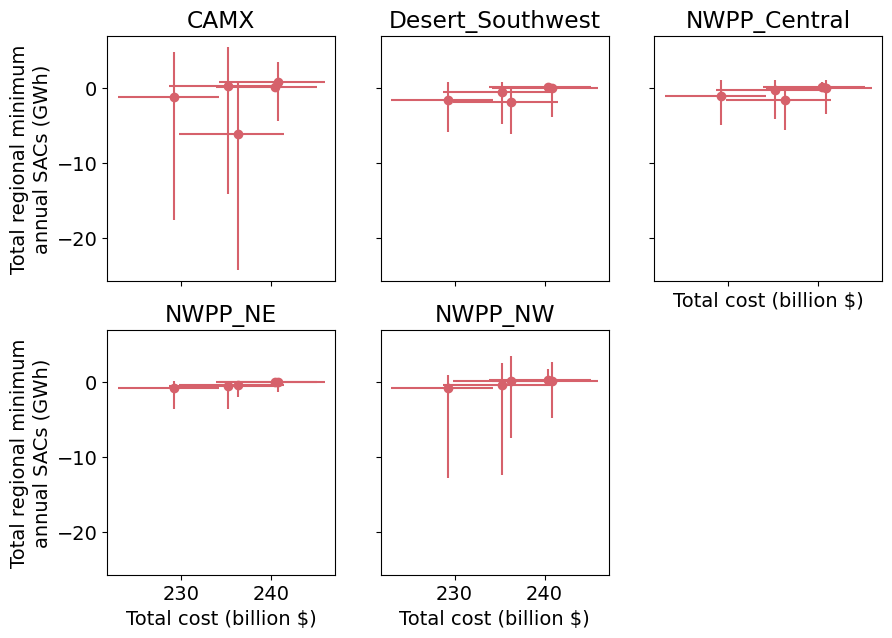

In [35]:
fig,ax=plt.subplots(2,3,figsize=(10,7),sharey=True,sharex=True)

for idx,region in enumerate(all_regions):
    row = idx//3
    column = idx%3
    
    
    
    for item in sorted(pathway_rename_dict.values()):
        reqd_df_pway = reqd_df_regs[reqd_df_regs.index.str.startswith(item)]
        ax[row,column].errorbar(reqd_df_pway['total_cost']['mean'],
                           reqd_df_pway[region]['mean']/1e3,
                           xerr = [reqd_df_pway['total_cost']['mean'] - reqd_df_pway['total_cost']['min'].values,
                                   reqd_df_pway['total_cost']['max'].values - reqd_df_pway['total_cost']['mean']],
                           yerr = [reqd_df_pway[region]['mean']/1e3 - reqd_df_pway[region]['min'].values/1e3,
                                   reqd_df_pway[region]['max'].values/1e3 - reqd_df_pway[region]['mean']/1e3],
                     label=item,
                     fmt="o",
                     zorder=0,
                    c=decarb_color[item]
                    #cmap=cmap_SAC
                   )
        ax[row,column].set_title(region)

#ax[1,1].legend(title='Decarb. target', bbox_to_anchor=(1.3, 0.8), loc='upper left')

#plt.colorbar(scat)

ax[0,2].set_xlabel('Total cost (billion $)')
ax[1,0].set_xlabel('Total cost (billion $)')
ax[1,1].set_xlabel('Total cost (billion $)')
ax[0,0].set_ylabel('Total regional minimum\nannual SACs (GWh)')
ax[1,0].set_ylabel('Total regional minimum\nannual SACs (GWh)')

fig.delaxes(ax[1,2])

plt.show()            

In [115]:
reqd_df = fix_opcost_allfleets_stacked.copy()
reqd_df['total_cost'] = fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9
reqd_df['SAC'] = SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index]


In [117]:
reqd_df["total_cost"].median()

237.05595267097368

In [124]:
(reqd_df[reqd_df["total_cost"].index.get_level_values("fleet").str.endswith("r10i1191")]["total_cost"].max()-reqd_df["total_cost"].median())*100/reqd_df["total_cost"].median()

3.415973242532038

In [130]:
df1 = reqd_df[reqd_df["total_cost"].index.get_level_values("fleet").str.endswith("r10i1191")]
df1[df1.total_cost>0].total_cost.min()
(reqd_df[reqd_df["total_cost"].index.get_level_values("fleet").str.endswith("r10i1191")]["total_cost"].min()-reqd_df["total_cost"].median())*100/reqd_df["total_cost"].median()

-1.3605831322698003

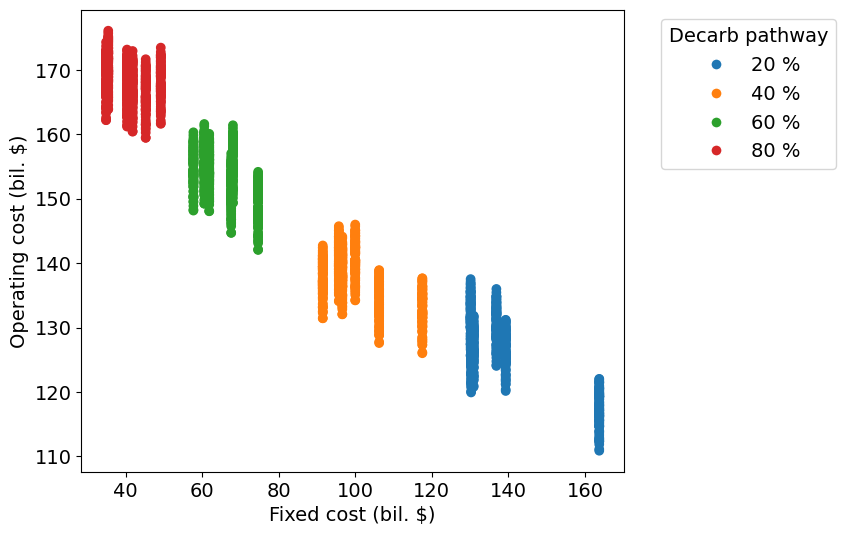

In [54]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9,
                   fix_opcost_allfleets_stacked['Opcost']/1e9,
                   #np.hstack([SAC_min_sumregions_df.xs(fleetname,level='fleet').values.flatten()/1e3 for fleetname in fixed_cost_df['fleet']]),
            c=[decarb_color[name] for name in fix_opcost_allfleets_stacked['pathway']],
            #cmap=cmap_SAC
           )

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in decarb_color.items()]
plt.legend(title='Decarb pathway', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Fixed cost (bil. $)')
plt.ylabel('Operating cost (bil. $)')
plt.show()            

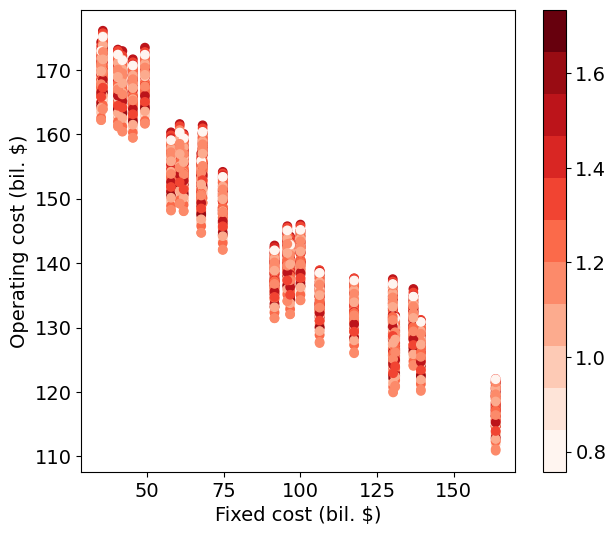

In [55]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9,
                   fix_opcost_allfleets_stacked['Opcost']/1e9,
            c=fix_opcost_allfleets_stacked['delT'],
            cmap=cm.get_cmap('Reds', 11)

           )


plt.colorbar(scat)
plt.xlabel('Fixed cost (bil. $)')
plt.ylabel('Operating cost (bil. $)')
plt.show()            

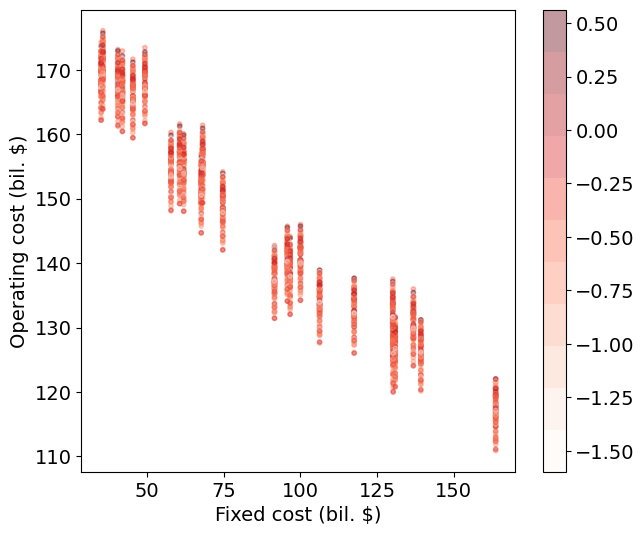

In [56]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9,
                   fix_opcost_allfleets_stacked['Opcost']/1e9,
                   s=10,alpha=0.4,
            c=fix_opcost_allfleets_stacked['delRH'],
            cmap=cm.get_cmap('Reds', 11)

           )


plt.colorbar(scat)
plt.xlabel('Fixed cost (bil. $)')
plt.ylabel('Operating cost (bil. $)')
plt.show()            

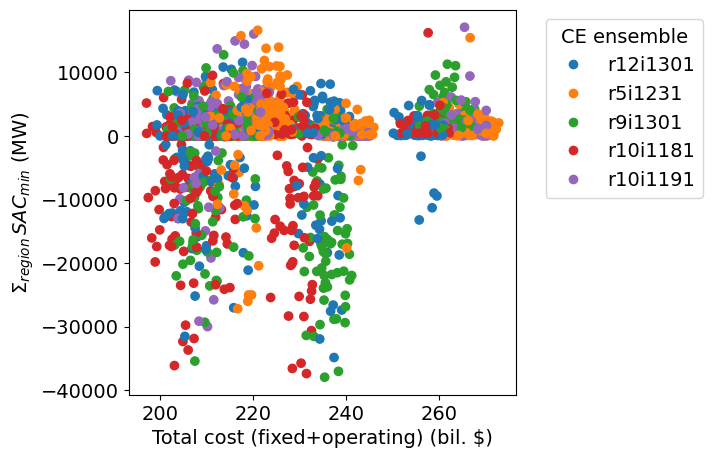

In [26]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9,
                   SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index],
            c=[CEens_color[name[5:]] for name in SAC_min_sumregions_df.index.get_level_values('fleet')],
            #cmap=cmap_SAC
           )

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in CEens_color.items()]
plt.legend(title='CE ensemble', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (fixed+operating) (bil. $)')
plt.ylabel(r'$\Sigma_{region}\,SAC_{min}$ (MW)')
plt.show()            

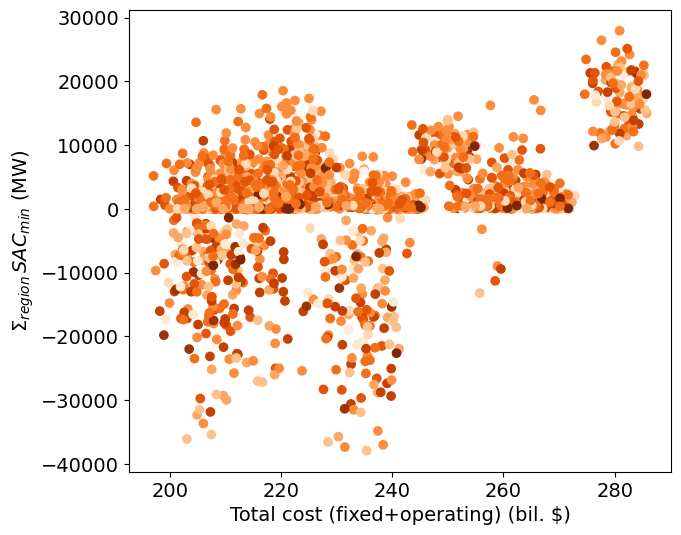

In [60]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9,
                   SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index],
            c=fix_opcost_allfleets_stacked['delT'],
            cmap=cmap_regret
           )

# add a legend
#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in CEens_color.items()]
#plt.legend(title='CE ensemble', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (fixed+operating) (bil. $)')
plt.ylabel(r'$\Sigma_{region}\,SAC_{min}$ (MW)')
plt.show()            

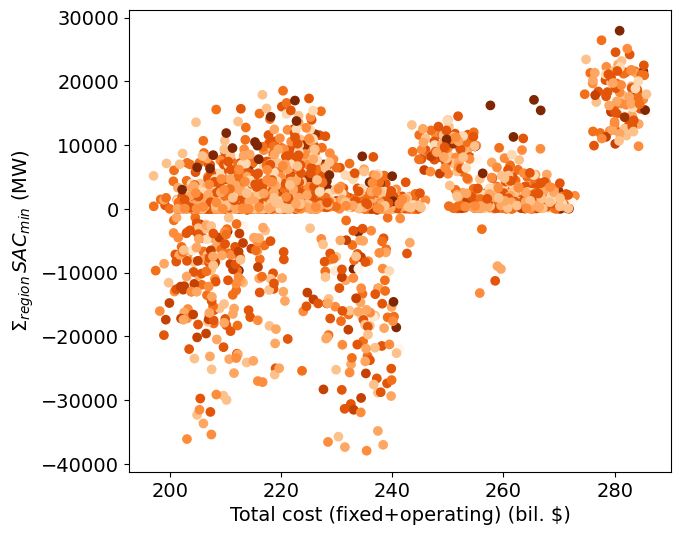

In [61]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9,
                   SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index],
            c=fix_opcost_allfleets_stacked['delRH'],
            cmap=cmap_regret
           )

# add a legend
#handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in CEens_color.items()]
#plt.legend(title='CE ensemble', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (fixed+operating) (bil. $)')
plt.ylabel(r'$\Sigma_{region}\,SAC_{min}$ (MW)')
plt.show()            

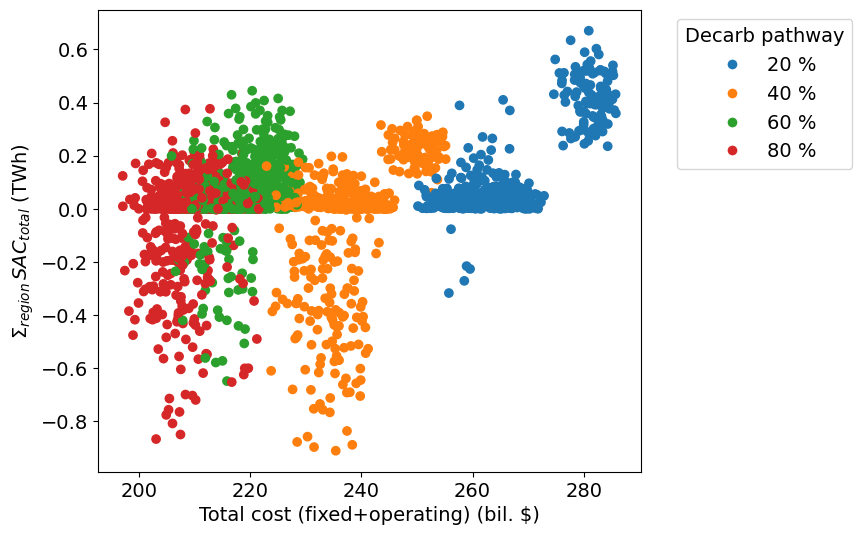

In [49]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9,
                   SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index]*24/1e6,
            c=[decarb_color[name[:4]] for name in SAC_min_sumregions_df.index.get_level_values('fleet')],
            #cmap=cmap_SAC
           )

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in decarb_color.items()]
plt.legend(title='Decarb pathway', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (fixed+operating) (bil. $)')
plt.ylabel(r'$\Sigma_{region}\,SAC_{total}$ (TWh)')
plt.show()            

# r19 based fleet

In [133]:
SAC_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

ENS_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

CO2_allfleets = pd.DataFrame()
opcost_allfleets = pd.DataFrame()

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    #if invest_ens == 'r19i1231p1f2':
    #    continue
    if pathway not in pathway_rename_dict.keys():
        continue
    
    SAC_fleet = xr.concat([xr.open_mfdataset([results_dir+'/SAC_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+year+'_'+str(i)+'.nc' for year in ['2030','2040']])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    SAC_fleet = SAC_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    SAC_allfleets = xr.merge([SAC_allfleets,SAC_fleet])

    ENS_fleet = xr.concat([xr.open_mfdataset([results_dir+'/ENS_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+year+'_'+str(i)+'.nc' for year in ['2030','2040']])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    ENS_fleet = ENS_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    ENS_allfleets = xr.merge([ENS_allfleets,ENS_fleet])

    
    co_year = '2040'
    CO2_fleets = pd.concat([pd.read_csv(results_dir+'/CO2_emis_pway'
                                        +pathway+'_invens'+invest_ens
                                        +'_year'+year+'_'+str(i)+'.csv')
                            for i in range(10) for year in [co_year]])
    
    CO2_fleets['year'] = np.repeat(pd.DatetimeIndex([co_year]),100)
    CO2_fleets = CO2_fleets.set_index(['year','ensemble_forcing'])
    CO2_fleets.columns = [pathway_rename_dict[pathway]+', '+invest_ens[:-4]]
    CO2_fleets = CO2_fleets/(pd.read_csv(base_dir+'WECCC'+pathway+'EM'+invest_ens+
                                        '/'+co_year+'/CE/co2CapCE'
                                         +co_year+'.csv',index_col=0).values.sum()\
                             *2000/2)
                 # CO2 cap is specified in tons for 2 years. 
                 #So multiply by 2000 to get lbs and divide by 2 for one year.
    
    CO2_allfleets = pd.concat([CO2_allfleets,CO2_fleets],axis=1)
        
    opcost_fleets = pd.read_csv(results_dir+'/opcost_all_pway'
                                           +pathway+'_invens'+invest_ens
                                           +'.csv',index_col=0).sum(axis=1).to_frame()
                               
    
    opcost_fleets['year'] = np.repeat(pd.DatetimeIndex(['2040']),100)
    opcost_fleets = opcost_fleets.reset_index().set_index(['year','ensemble_forcing'])
    opcost_fleets.columns = [pathway_rename_dict[pathway]+','+invest_ens[:-4]]
    
    opcost_allfleets = pd.concat([opcost_allfleets,opcost_fleets],axis=1)

SAC_allfleets['pathway'] = ('fleet',[val[:4] for val in SAC_allfleets.fleet.values])
SAC_allfleets['invest_ens'] = ('fleet',[val[5:] for val in SAC_allfleets.fleet.values])
SAC_allfleets = SAC_allfleets.set_coords(('pathway','invest_ens'))

ENS_allfleets['pathway'] = ('fleet',[val[:4] for val in ENS_allfleets.fleet.values])
ENS_allfleets['invest_ens'] = ('fleet',[val[5:] for val in ENS_allfleets.fleet.values])
ENS_allfleets = ENS_allfleets.set_coords(('pathway','invest_ens'))

CO2_allfleets = CO2_allfleets.sort_index(axis=1)
CO2_allfleets = CO2_allfleets[np.roll(CO2_allfleets.columns,3)]
opcost_allfleets = opcost_allfleets.sort_index(axis=1)
SAC_master = SAC_allfleets.copy()
SAC_master = SAC_master.roll(fleet=3,roll_coords=True)

In [139]:
SAC_allfleets.sel(fleet='40 %,r19i1231').sel(time='2040').to_dataframe()[all_regions].min()

CAMX               -8.367351e-11
Desert_Southwest   -2.091838e-11
NWPP_Central        3.860000e+02
NWPP_NE             3.410605e-13
NWPP_NW            -7.560175e-12
dtype: float64

In [215]:
SAC_allfleets.where(SAC_allfleets['pathway']=='20 %',drop=True).sel(time='2040').min('time').min('reliability_ens').compute().to_dataframe().drop(['pathway','invest_ens'],axis=1).drop(['20 %,r19i1231'],axis=0).mean().mean()/1e3

-0.5758484398507449

In [216]:
SAC_allfleets.where(SAC_allfleets['pathway']=='20 %',drop=True).sel(time='2040').min('time').max('reliability_ens').compute().to_dataframe().drop(['pathway','invest_ens'],axis=1).drop(['20 %,r19i1231'],axis=0).mean().mean()/1e3

3.1351777154792524

In [217]:
SAC_allfleets.where(SAC_allfleets['invest_ens']=='r19i1231',drop=True)['CAMX'].sel(time='2040').min('time').min('reliability_ens').compute()/1e3

<xarray.DataArray 'CAMX' (fleet: 4)>
array([ 1.09139364e-14, -8.36735126e-14, -9.45874490e-14, -5.27506927e-14])
Coordinates:
  * fleet       (fleet) object '20 %,r19i1231' ... '80 %,r19i1231'
    pathway     (fleet) <U4 '20 %' '40 %' '60 %' '80 %'
    invest_ens  (fleet) <U8 'r19i1231' 'r19i1231' 'r19i1231' 'r19i1231'

In [218]:
SAC_allfleets.where(SAC_allfleets['invest_ens']=='r19i1231',drop=True).sel(time='2040').min('time').min('reliability_ens').compute().to_dataframe()

CAMX  Desert_Southwest  NWPP_Central       NWPP_NE  \
fleet                                                                       
20 %,r19i1231  1.091394e-11     -1.364242e-12  2.142850e+03  3.410605e-13   
40 %,r19i1231 -8.367351e-11     -2.091838e-11  3.860000e+02  3.410605e-13   
60 %,r19i1231 -9.458745e-11     -1.818989e-11 -9.822543e-11 -9.549694e-12   
80 %,r19i1231 -5.275069e-11     -1.034550e-10 -1.409717e-11 -6.821210e-12   

                    NWPP_NW pathway invest_ens  
fleet                                           
20 %,r19i1231 -1.105036e-10    20 %   r19i1231  
40 %,r19i1231 -7.560175e-12    40 %   r19i1231  
60 %,r19i1231 -4.774847e-12    60 %   r19i1231  
80 %,r19i1231 -1.000444e-11    80 %   r19i1231

In [219]:
SAC_allfleets.where(SAC_allfleets['invest_ens']=='r19i1231',drop=True).sel(time='2040').min('time').max('reliability_ens').compute().to_dataframe().drop(['pathway','invest_ens'],axis=1).mean().mean()/1e3

4.324026391729643

In [220]:
SAC_allfleets['CAMX'].sel(time='2040').min('time').max('reliability_ens').compute()/1e3

<xarray.DataArray 'CAMX' (fleet: 24)>
array([ 1.92949023,  1.99537444,  2.49701882, 12.96071045,  3.67426372,
        1.86353   ,  4.7813505 ,  0.880955  ,  5.40883161,  2.7684139 ,
        3.38615129,  0.61220552,  4.35412785,  6.6799499 ,  6.7856376 ,
        8.87958397,  7.34608124,  5.8957091 ,  4.5864175 ,  5.77525926,
        2.2702942 ,  9.8093987 ,  6.64934637,  5.07217597])
Coordinates:
  * fleet       (fleet) object '20 %,r10i1181' ... '80 %,r9i1301'
    pathway     (fleet) <U4 '20 %' '20 %' '20 %' '20 %' ... '80 %' '80 %' '80 %'
    invest_ens  (fleet) <U8 'r10i1181' 'r10i1191' ... 'r5i1231' 'r9i1301'

In [23]:
y_labels = []
idx = 0
for label in SAC_master['fleet'].values:
    if idx%6 == 3:
        y_labels.append(label[5:])
    else:
        y_labels.append(label[5:])
        
    idx+=1

In [74]:
SAC_allfleets_yearmin.sel(time='2040').to_dataframe()[all_regions].xs("40 %,r19i1231",level=1).min(axis=0)

CAMX               -8.367351e-11
Desert_Southwest   -2.091838e-11
NWPP_Central        3.860000e+02
NWPP_NE             3.410605e-13
NWPP_NW            -7.560175e-12
dtype: float64

In [75]:
SAC_allfleets_yearmin.sel(time='2040').to_dataframe()[all_regions].xs("40 %,r19i1231",level=1).max(axis=0)

CAMX                2768.413897
Desert_Southwest      90.843744
NWPP_Central        8470.003494
NWPP_NE             2105.598284
NWPP_NW             4689.144107
dtype: float64

In [78]:
(CO2_allfleets.loc[year]["40 %, r19i1231"]>1).sum()

3

[[34  1]
 [38  1]
 [43  1]
 [46  1]
 [64  1]
 [74  1]]


NameError: name 'y_labels' is not defined

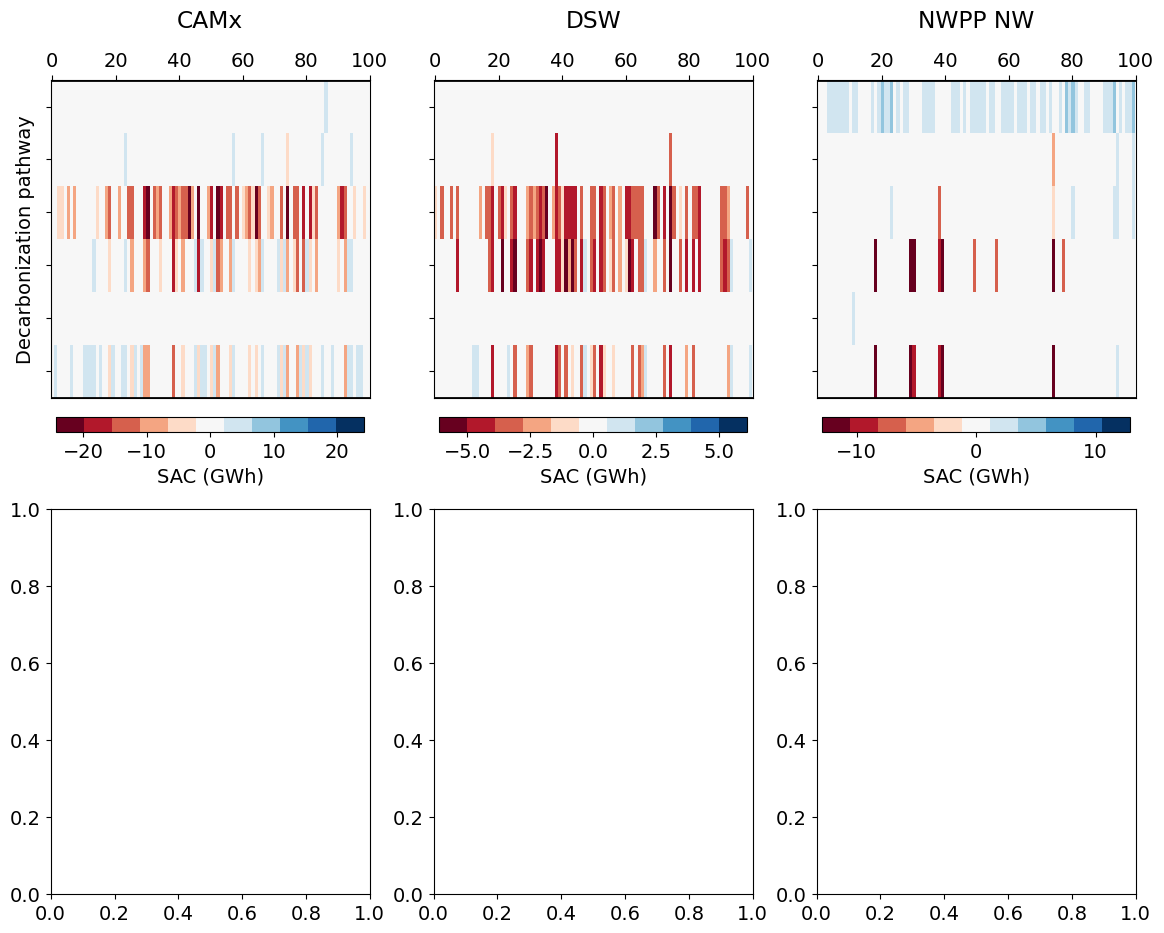

In [67]:
#SAC_master = actual_SAC
SAC_allfleets_yearmin = SAC_master.resample(time='1Y').min()
fig,ax = plt.subplots(2,3,figsize=(14,11))

SAC_min_sumregions_df = SAC_allfleets_yearmin.sel(time='2040').to_dataframe().sum(axis=1)

for idx,region in enumerate(['CAMX','Desert_Southwest','NWPP_NW']):

    ########
    for idx_yr,year in enumerate(['2040']):
        d = SAC_allfleets_yearmin.sel(time=year)[region]
        #d = SAC_allfleets.sel(time=slice(year+'-06',year+'-09')).min('time')[region]
        SAC_np = d.values.reshape(len(SAC_master.fleet),len(ens_info))
        lim_val = np.max(np.abs(SAC_np))
        
        if region == 'CAMX' and year == '2040':
            unique, counts = np.unique(SAC_np.argmin(axis=1), return_counts=True)
            print(np.asarray((unique, counts)).T)
            #print(SAC_np.argmin(axis=1))

        im = ax[0,idx].imshow(SAC_np/1e3,aspect=100/len(SAC_master.fleet),
                   cmap=cmap_SAC,
                   vmin=-1*lim_val/1e3,vmax=lim_val/1e3
                  )
        
        # Minor ticks
        ax[0,idx].set_yticks(np.arange(-.5, 6*len(pathway_rename_dict), 6), minor=True)
        ax[0,idx].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
        ax[0,idx].tick_params(which='minor', bottom=False, left=False)

        ax[0,idx].set_xticks(ticks=[0,20,40,60,80,100])
        ax[0,idx].xaxis.tick_top()
        
        ax[0,idx].set_title(all_regions[region],y=1.14)

        cbar = fig.colorbar(im,ax=ax[0,idx],label='SAC (GWh)',fraction=0.04, pad=0.05,location='bottom',
                           #format=lambda x, _: int(x/1e3)
                           )      
        
        ax[0,idx].set_yticks(ticks=range(len(d['fleet'].values)),labels=[]) 


ax[0,0].set_ylabel('Decarbonization pathway')
ax[0,0].set_yticks(ticks=range(len(d['fleet'].values)),labels=y_labels,fontsize=12)

ax[0,0].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,0].set_xlabel('Ensemble member')
ax[0,0].xaxis.set_label_position('top') 
ax[0,0].xaxis.tick_top() 

ax[0,1].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,1].set_xlabel('Ensemble member')
ax[0,1].xaxis.set_label_position('top') 
ax[0,1].xaxis.tick_top() 

ax[0,2].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,2].set_xlabel('Ensemble member')
ax[0,2].xaxis.set_label_position('top') 
ax[0,2].xaxis.tick_top() 

for fleet in ax[0,0].get_yticklabels():
   if fleet.get_text() == "r19i1231":
      fleet.set_fontweight('bold')

for idx,year in enumerate([co_year]):
    vmin=CO2_allfleets.loc[year].min().min()
    vmax=CO2_allfleets.loc[year].max().max()

    im1 = ax[1,1].imshow(CO2_allfleets.loc[year].to_numpy().T,
                        cmap=cmap_CO2,aspect=100/len(SAC_allfleets.fleet),
                       #vmin=0.75,vmax=1.25
                        vmin=1-abs(1-(vmin if (1-vmin) > vmax-1 else vmax)),
                        vmax=1+abs(1-(vmin if (1-vmin) > vmax-1 else vmax)),
                       )
    
    # Minor ticks
    ax[1,1].set_yticks(np.arange(-.5, 6, 6), minor=True)
    ax[1,1].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
    ax[1,1].tick_params(which='minor', bottom=False, left=False)
    
ax[1,1].set_title('WECC',y=1.14)

ax[1,1].set_ylabel('Decarbonization pathway')
ax[1,1].set_yticks(ticks=range(len(d['fleet'].values)),labels=y_labels,fontsize=12)

ax[1,1].set_xticks(ticks=[0,20,40,60,80,100])
ax[1,1].set_xlabel('Ensemble member')
ax[1,1].xaxis.set_label_position('top') 
ax[1,1].xaxis.tick_top() 

cbar_co2 = fig.colorbar(im1,ax=ax[1,1], label=r'$CO_{2}$'+' emission for RA ensemble\n as fraction of CE fleet emissions',
                fraction=0.04, pad=0.05,
                location='bottom'
               )


for fleet in ax[1,1].get_yticklabels():
   if fleet.get_text() == "r19i1231":
      fleet.set_fontweight('bold')

fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])

plt.tight_layout()
#plt.savefig('figures/SAC_3regions_allfleets.png')#, bbox_inches='tight')
plt.show()

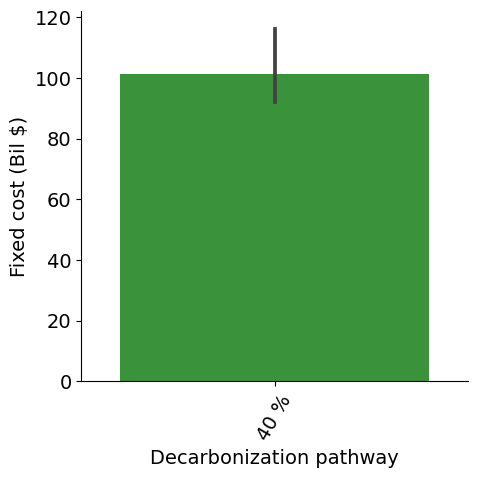

In [79]:
import matplotlib.ticker as ticker

base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

fixed_cost_list = []

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]
year = '2040'

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    #if invest_ens == 'r19i1231p1f2':
    #    continue

    if pathway not in pathway_rename_dict.keys():
        continue

    fixed_cost = pd.read_csv(results_dir+'fixedcost2040_pway'
                             +pathway+'_invens'+invest_ens+'_year'+year+'.csv',index_col=0).values[0,0]*1e3#/1e9
    
    fixed_cost_list.append([invest_ens,pathway_rename_dict[pathway],fixed_cost])
    
fixed_cost_df = pd.DataFrame(fixed_cost_list,columns=['invest_ens','pathway','Fixed cost (Bil $)'])
fixed_cost_df = fixed_cost_df.sort_values('pathway')
fixed_cost_df['fleet'] = fixed_cost_df['pathway']+','+ fixed_cost_df['invest_ens'].apply(lambda x: x[:-4])

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size']= 14

g = sns.catplot(data=fixed_cost_df.sort_values('pathway',ascending=False),kind='bar',errorbar=('pi',95),
            x='pathway',y='Fixed cost (Bil $)',color='tab:green'
               )

for idx,axes in enumerate(g.axes.flat):
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Decarbonization pathway')
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e9))
    axes.yaxis.set_major_formatter(ticks_y)

plt.tight_layout()
plt.show()

In [80]:
delt_delrh = xr.open_dataset('../capacity_factors/temp_RH_midcentury_diff_WECC_2020to2040diff.nc')
delt_delrh_df = delt_delrh.to_dataframe().reset_index(level=1,drop=True).dropna()

fix_opcost_allfleets_stacked = opcost_allfleets.rename_axis("fleet", axis="columns").stack().reset_index()
fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.rename({'ensemble_forcing':'reliability_ens',0:'Opcost'},axis=1)


fix_opcost_allfleets_stacked['invest_ens'] = [item[5:] for item in fix_opcost_allfleets_stacked['fleet']]
fix_opcost_allfleets_stacked['pathway'] = [item[:4] for item in fix_opcost_allfleets_stacked['fleet']]
#fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.drop('fleet',axis=1)
fix_opcost_allfleets_stacked = fix_opcost_allfleets_stacked.set_index(['reliability_ens','fleet'])

fix_opcost_allfleets_stacked['Fixcost'] = [fixed_cost_df.loc[fixed_cost_df['fleet'].isin([fleetname])]['Fixed cost (Bil $)'].values[0]
                                                             for fleetname in fix_opcost_allfleets_stacked.index.get_level_values('fleet')] 
fix_opcost_allfleets_stacked['Fixcost'] = fix_opcost_allfleets_stacked['Fixcost']
fix_opcost_allfleets_stacked['delT'] = [delt_delrh_df.loc[ens_id]['TREFHT']
                                        for ens_id in fix_opcost_allfleets_stacked.index.get_level_values('reliability_ens')] 
fix_opcost_allfleets_stacked['delRH'] = [delt_delrh_df.loc[ens_id]['RHREFHT']
                                        for ens_id in fix_opcost_allfleets_stacked.index.get_level_values('reliability_ens')] 

In [81]:
reset_df = fix_opcost_allfleets_stacked.reset_index()

In [82]:
reset_df[reset_df['fleet'].str.startswith("20 %")]['Fixcost'].unique()

array([], dtype=float64)

In [83]:
(1.63714537e+11 - np.array([1.30909036e+11, 1.39286024e+11, 1.30247082e+11,
       1.36852326e+11, 1.30126478e+11]).mean())*100/np.array([1.30909036e+11, 1.39286024e+11, 1.30247082e+11,
       1.36852326e+11, 1.30126478e+11]).mean()

22.647137448395274

In [84]:
reset_df[reset_df['fleet'].str.startswith("20 %,r19")]['Fixcost'].unique()

array([], dtype=float64)

In [85]:
SAC_min_sumregions_df = SAC_allfleets.sel(time='2040').min('time').to_dataframe().sum(axis=1)
SAC_sumregions_df = SAC_allfleets.sel(time='2040').sum('time').to_dataframe().sum(axis=1)

In [86]:
reset_df = fix_opcost_allfleets_stacked.reset_index()
reset_df[reset_df['fleet'].str.startswith('20 %')]['Fixcost'].unique()

array([], dtype=float64)

In [87]:
reqd_df = fix_opcost_allfleets_stacked.copy()
reqd_df['total_cost'] = fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9
reqd_df['SAC'] = SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index]

reqd_df = reqd_df.groupby('fleet').agg({'total_cost': ['mean', 'min', 'max'],
                              'SAC': ['mean', 'min', 'max']
                             })

In [88]:
reqd_df[reqd_df.index.str.endswith('r19i1231')]['total_cost']['mean']

fleet
40 %,r19i1231    250.303859
Name: mean, dtype: float64

In [198]:
(281.089837 - np.mean(np.array([257.983941, 265.854526, 256.665089, 267.461069, 262.356338])))

19.025644399999976

In [235]:
(281.089837 - np.mean(np.array([257.983941, 265.854526, 256.665089, 267.461069, 262.356338*100])))/np.mean(np.array([257.983941, 265.854526, 256.665089, 267.461069, 262.356338]))

-19.74947357993234

In [197]:
reqd_df[reqd_df.index.str.startswith('20 %')]['total_cost']['mean']

fleet
20 %,r10i1181    257.983941
20 %,r10i1191    265.854526
20 %,r12i1301    256.665089
20 %,r19i1231    281.089837
20 %,r5i1231     267.461069
20 %,r9i1301     262.356338
Name: mean, dtype: float64

In [82]:
(281.089837 - np.array([257.98394057, 265.85452623, 256.66508861,
       267.46106877, 262.35633771]).mean())*100/np.array([257.98394057, 265.85452623, 256.66508861,
       267.46106877, 262.35633771]).mean()

7.259917674886872

In [81]:
reqd_df[reqd_df.index.str.startswith('20 %')]['total_cost']['mean'].values

array([257.98394057, 265.85452623, 256.66508861, 281.08983671,
       267.46106877, 262.35633771])

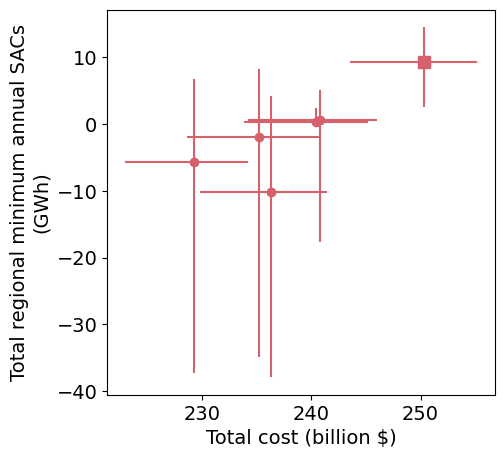

In [89]:
for item in sorted(pathway_rename_dict.values()):
    reqd_df_pway = reqd_df[reqd_df.index.str.startswith(item)]
    reqd_df_pway_r19 = reqd_df_pway[reqd_df_pway.index.str.endswith('r19i1231')]
    reqd_df_pway = reqd_df_pway[~reqd_df_pway.index.str.endswith('r19i1231')]
    plt.errorbar(reqd_df_pway['total_cost']['mean'],
                       reqd_df_pway['SAC']['mean']/1e3,
                       xerr = [reqd_df_pway['total_cost']['mean'] - reqd_df_pway['total_cost']['min'].values,
                               reqd_df_pway['total_cost']['max'].values - reqd_df_pway['total_cost']['mean']],
                       yerr = [reqd_df_pway['SAC']['mean']/1e3 - reqd_df_pway['SAC']['min'].values/1e3,
                               reqd_df_pway['SAC']['max'].values/1e3 - reqd_df_pway['SAC']['mean']/1e3],
                 label=item,
                 fmt="o",
                 zorder=0,
                c=decarb_color[item]
                #cmap=cmap_SAC
               )
    
    plt.errorbar(reqd_df_pway_r19['total_cost']['mean'],
                   reqd_df_pway_r19['SAC']['mean']/1e3,
                   xerr = [reqd_df_pway_r19['total_cost']['mean'] - reqd_df_pway_r19['total_cost']['min'].values,
                           reqd_df_pway_r19['total_cost']['max'].values - reqd_df_pway_r19['total_cost']['mean']],
                   yerr = [reqd_df_pway_r19['SAC']['mean']/1e3 - reqd_df_pway_r19['SAC']['min'].values/1e3,
                           reqd_df_pway_r19['SAC']['max'].values/1e3 - reqd_df_pway_r19['SAC']['mean']/1e3],
             label=item+" r19i1231",
             fmt="s",markersize=8,
             zorder=0,
            c=decarb_color[item]
            #cmap=cmap_SAC
           )

#plt.legend(title='Decarb pathway', bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (billion $)')
plt.ylabel('Total regional minimum annual SACs\n(GWh)')
plt.show()            

In [96]:
np.sort(reqd_df["total_cost"]["mean"])

array([229.25751924, 235.25329494, 236.31082626, 240.39938024,
       240.82428846, 250.30385864])

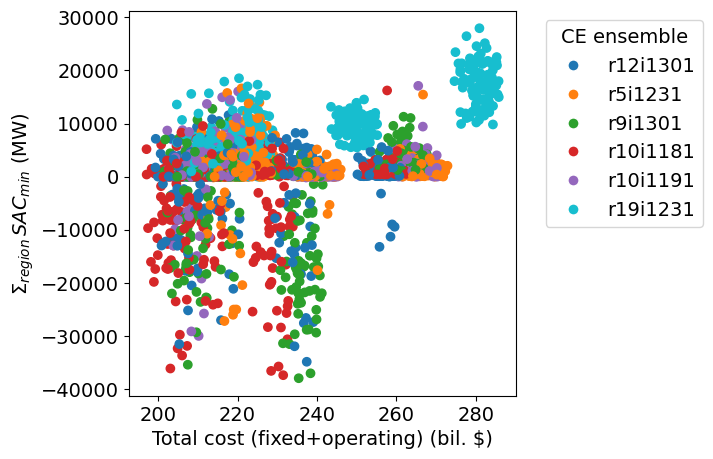

In [111]:
from matplotlib.lines import Line2D  # for legend handle
scat = plt.scatter(fix_opcost_allfleets_stacked['Fixcost']/1e9+fix_opcost_allfleets_stacked['Opcost']/1e9,
                   SAC_min_sumregions_df.loc[fix_opcost_allfleets_stacked.index],
            c=[CEens_color[name[5:]] for name in SAC_min_sumregions_df.index.get_level_values('fleet')],
            #cmap=cmap_SAC
           )

# add a legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in CEens_color.items()]
plt.legend(title='CE ensemble', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.colorbar(scat)
plt.xlabel('Total cost (fixed+operating) (bil. $)')
plt.ylabel(r'$\Sigma_{region}\,SAC_{min}$ (MW)')
plt.show()            

In [15]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

gentype_across_ens_df = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','pathway'])

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if not (pathway in pathway_rename_dict.keys()):
        continue

    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

    #region_gentype_all_df = fleet_ds.sel(time=['2022','2024','2026','2030','2036','2040'])\

    
    gentype_all_df = fleet_ds.sel(time=['2022','2030','2040'])\
                                .to_dataframe()
    gentype_all_df = gentype_all_df.loc[gentype_all_df['Retired'].isin([False])]
    gentype_all_df = gentype_all_df.groupby(['time','PlantType'])['Capacity (MW)']\
                                    .sum().reset_index()
    
    gentype_all_df['time'] = gentype_all_df['time'].dt.year
    gentype_all_df['member_id'] = np.repeat([invest_ens],len(gentype_all_df))
    gentype_all_df['pathway'] = np.repeat([pathway_rename_dict[pathway]],
                                           len(gentype_all_df))
    
    gentype_all_df = gentype_all_df.loc[~gentype_all_df['PlantType'].isin(['ST','CT'])]
    gentype_across_ens_df = pd.concat([gentype_across_ens_df,gentype_all_df])

In [24]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

gentype_across_ens_df_r19 = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','pathway'])

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if not (pathway in pathway_rename_dict.keys()):
        continue
    if invest_ens == 'r19i1231p1f2':

        fleet_name = 'WECCC'+pathway+'EM'+invest_ens

        compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
        compressed_units = SAC.rename_plant_types(compressed_units)
        compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

        fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

        #region_gentype_all_df = fleet_ds.sel(time=['2022','2024','2026','2030','2036','2040'])\


        gentype_all_df = fleet_ds.sel(time=['2022','2030','2040'])\
                                    .to_dataframe()
        gentype_all_df = gentype_all_df.loc[gentype_all_df['Retired'].isin([False])]
        gentype_all_df = gentype_all_df.groupby(['time','PlantType'])['Capacity (MW)']\
                                        .sum().reset_index()

        gentype_all_df['time'] = gentype_all_df['time'].dt.year
        gentype_all_df['member_id'] = np.repeat([invest_ens],len(gentype_all_df))
        gentype_all_df['pathway'] = np.repeat([pathway_rename_dict[pathway]],
                                               len(gentype_all_df))

        gentype_all_df = gentype_all_df.loc[~gentype_all_df['PlantType'].isin(['ST','CT'])]
        gentype_across_ens_df_r19 = pd.concat([gentype_across_ens_df_r19,gentype_all_df])

In [44]:
diff_df_across_ens = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','pathway'])

for member_id in gentype_across_ens_df.member_id.unique():
    reqd_caps = gentype_across_ens_df[gentype_across_ens_df["member_id"].isin([member_id])]
    reqd_caps = reqd_caps.set_index(["pathway","PlantType","time"])["Capacity (MW)"]
    diff_df = (gentype_across_ens_df_r19.set_index(["pathway","PlantType","time"])["Capacity (MW)"] 
           - reqd_caps).to_frame()#.reset_index()
    diff_df['member_id'] = np.repeat([member_id],len(diff_df))
    
    diff_df_across_ens = pd.concat([diff_df_across_ens,diff_df.reset_index()])

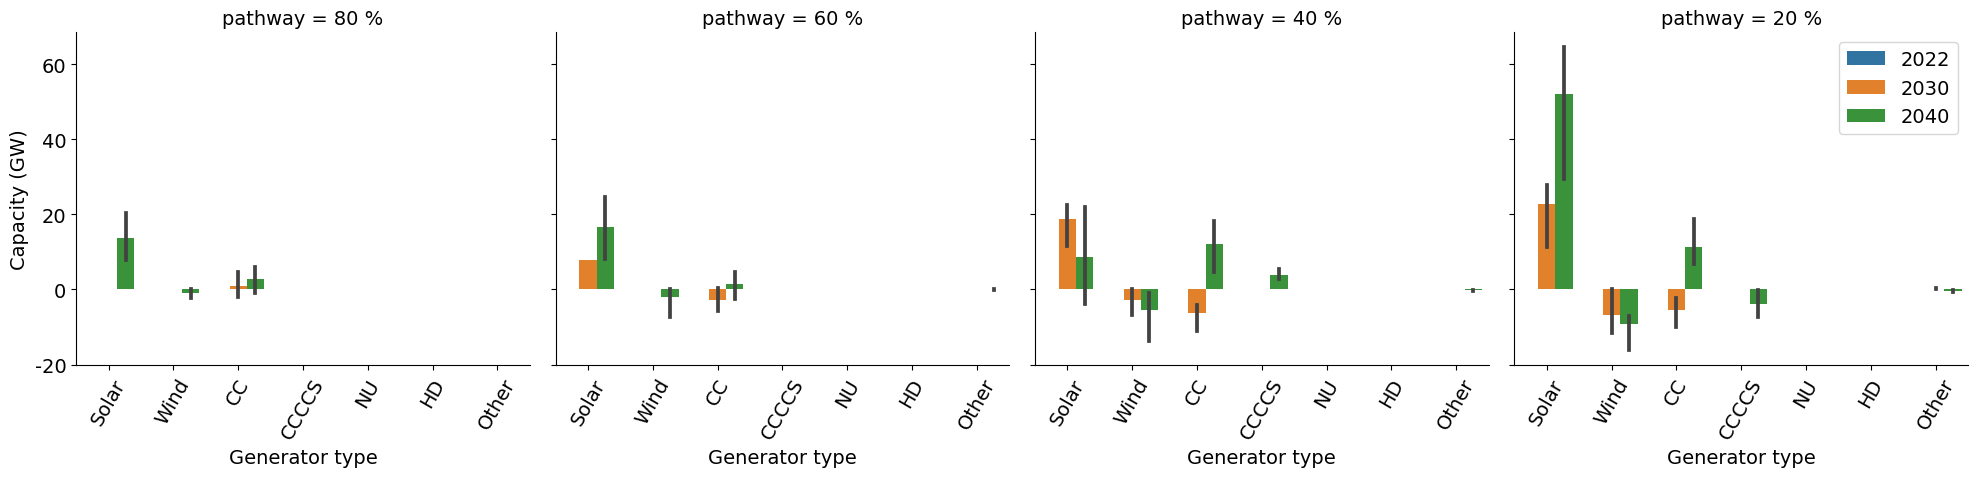

In [47]:
from matplotlib.ticker import FuncFormatter

#plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size']= 14

g = sns.catplot(data=diff_df_across_ens.sort_values('pathway',ascending=False),kind='bar',
                errorbar=("pi", 100),
            x='PlantType',y='Capacity (MW)',hue='time',
            col='pathway',col_wrap=4,
            order=['Solar','Wind','CC','CCCCS','NU','HD','Other'],
            col_order=pathway_rename_dict.values(),
            sharey=True,sharex=True,legend=False,
               )

for idx,axes in enumerate(g.axes.flat):
    #print(axes.get_xticklabels())
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Generator type')
    axes.set_ylabel('Capacity (GW)')
    axes.set_yticklabels(axes.get_yticks()/1000)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1e3)))
    #axes.set_title([item for item in pathway_rename_dict.values()][idx])
    #axes.set_ylim([0,3e5])
    #ax[row_id,col_id].set_title(pathway)
    #axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

names = [list(filter(None, re.split(r'WECCC|EM', subdir_name))) 
 for subdir_name in subdirectories]
names.sort()

gentype_across_ens_df_subregion = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','region'])
gentype_across_ens_df_subregion_r19 = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','region'])

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if not (pathway in pathway_rename_dict.keys()):
        continue
    if not (pathway_rename_dict[pathway] in reqd_pathway):
        continue
        
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)


    #region_gentype_all_df = fleet_ds.sel(time=['2022','2024','2026','2030','2036','2040'])\


    gentype_all_df = fleet_ds.sel(time=['2022','2030','2040'])\
                                .to_dataframe()
    gentype_all_df = gentype_all_df.loc[gentype_all_df['Retired'].isin([False])]
    gentype_all_df = gentype_all_df.groupby(['time','PlantType','region'])['Capacity (MW)']\
                                    .sum().reset_index()

    gentype_all_df['time'] = gentype_all_df['time'].dt.year
    gentype_all_df['member_id'] = np.repeat([invest_ens],len(gentype_all_df))
    gentype_all_df['pathway'] = np.repeat([pathway_rename_dict[pathway]],
                                           len(gentype_all_df))
    
    if invest_ens == 'r19i1231p1f2':
        gentype_across_ens_df_subregion_r19 = pd.concat([gentype_across_ens_df_subregion_r19,gentype_all_df])
    elif invest_ens == 'r5i1231p1f1':
        gentype_across_ens_df_subregion = pd.concat([gentype_across_ens_df_subregion,gentype_all_df])

diff_df = (gentype_across_ens_df_subregion_r19.set_index(["pathway","PlantType","time","region"])["Capacity (MW)"] 
           - gentype_across_ens_df_subregion.set_index(["pathway","PlantType","time","region"])["Capacity (MW)"])#.reset_index()

In [ ]:
#print([transmission_dict[key] for key in ['2022','2030','2040']])
from matplotlib.ticker import FuncFormatter

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size']= 16

g = sns.catplot(data=diff_df.reset_index(),kind='bar',
            x='PlantType',y='Capacity (MW)',hue='time',
            col='region',col_wrap=3,
            order=['Solar','Wind','CC','NU','HD','Other'],
            sharey=True,sharex=True,legend=False,
               )

for idx,axes in enumerate(g.axes.flat):
    #print(axes.get_xticklabels())
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Generator type')
    axes.set_ylabel('Capacity (GW)')
    #axes.set_ylim([0,130e3])
    axes.set_yticklabels(axes.get_yticks()/1000)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1e3)))
    name=axes.get_title()
    axes.set_title(name[8:])
#plt.suptitle(invest_ens)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize all fleets

In [28]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

gentype_across_ens_df = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','pathway'])

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if not (pathway in pathway_rename_dict.keys()):
        continue

    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

    #region_gentype_all_df = fleet_ds.sel(time=['2022','2024','2026','2030','2036','2040'])\

    
    gentype_all_df = fleet_ds.sel(time=['2022','2030','2040'])\
                                .to_dataframe()
    gentype_all_df = gentype_all_df.loc[gentype_all_df['Retired'].isin([False])]
    gentype_all_df = gentype_all_df.groupby(['time','PlantType'])['Capacity (MW)']\
                                    .sum().reset_index()
    
    gentype_all_df['time'] = gentype_all_df['time'].dt.year
    gentype_all_df['member_id'] = np.repeat([invest_ens],len(gentype_all_df))
    gentype_all_df['pathway'] = np.repeat([pathway_rename_dict[pathway]],
                                           len(gentype_all_df))
    
    gentype_all_df = gentype_all_df.loc[~gentype_all_df['PlantType'].isin(['ST','CT'])]
    gentype_across_ens_df = pd.concat([gentype_across_ens_df,gentype_all_df])

In [29]:
gentype_across_ens_df[gentype_across_ens_df.time.isin([2040])*
                      gentype_across_ens_df.pathway.isin(["20 %"])*
                      gentype_across_ens_df.PlantType.isin(["Solar"])
                     ].agg(['min', 'max'])

time PlantType  Capacity (MW)     member_id pathway
min  2040     Solar  107183.112109  r10i1181p1f1    20 %
max  2040     Solar  142320.740101   r9i1301p1f1    20 %

In [30]:
gentype_across_ens_df[gentype_across_ens_df.time.isin([2040])*
                      gentype_across_ens_df.pathway.isin(["20 %"])*
                      gentype_across_ens_df.PlantType.isin(["Wind"])
                     ].agg(['min', 'max'])

time PlantType  Capacity (MW)     member_id pathway
min  2040      Wind   40190.986590  r10i1181p1f1    20 %
max  2040      Wind   49222.998699   r9i1301p1f1    20 %

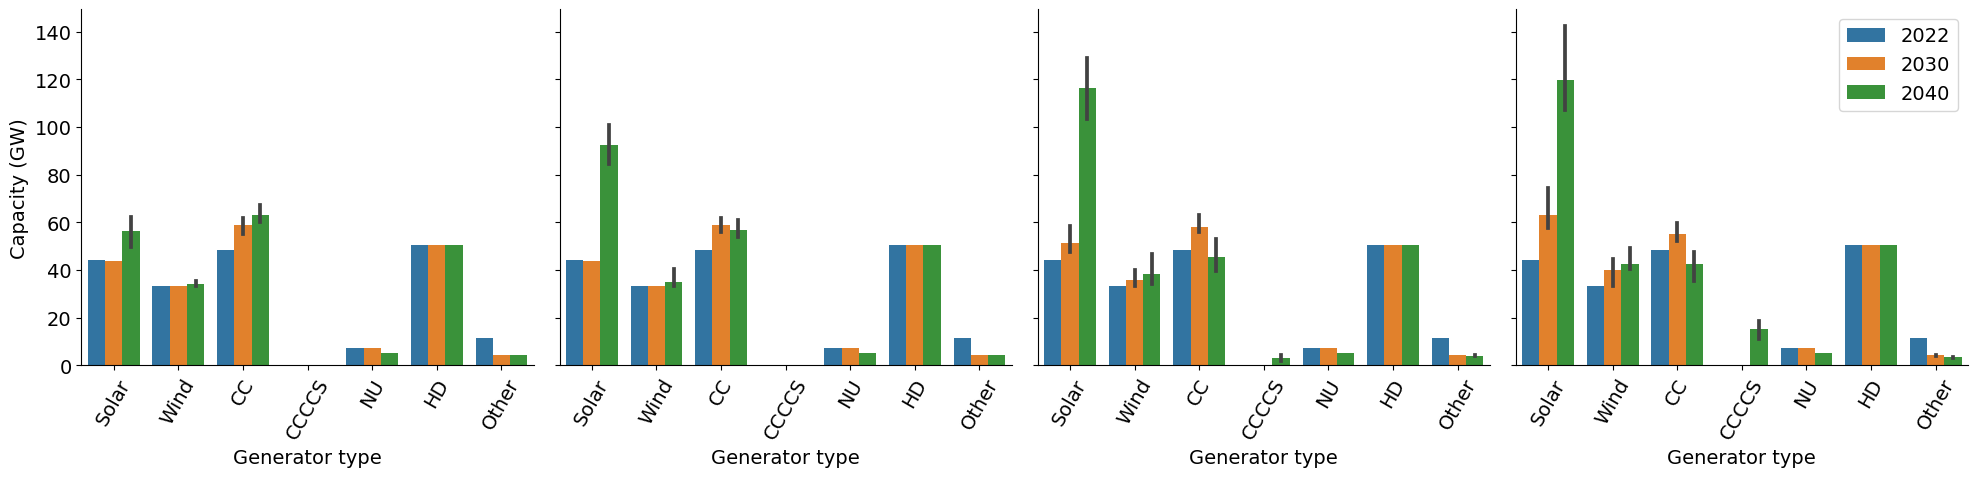

In [31]:
from matplotlib.ticker import FuncFormatter

#plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size']= 14

g = sns.catplot(data=gentype_across_ens_df.sort_values('pathway',ascending=False),kind='bar',
                errorbar=("pi", 100),
            x='PlantType',y='Capacity (MW)',hue='time',
            col='pathway',col_wrap=4,
            order=['Solar','Wind','CC','CCCCS','NU','HD','Other'],
            col_order=pathway_rename_dict.values(),
            sharey=True,sharex=True,legend=False,
               )

for idx,axes in enumerate(g.axes.flat):
    #print(axes.get_xticklabels())
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Generator type')
    axes.set_ylabel('Capacity (GW)')
    axes.set_yticklabels(axes.get_yticks()/1000)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1e3)))
    axes.set_title('')
    #axes.set_ylim([0,3e5])
    #ax[row_id,col_id].set_title(pathway)
    #axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
plt.legend()
plt.tight_layout()
plt.show()

## Plot regional caps

In [32]:
pathway_rename_dict

{'80RE0W0': '80 %', '60RE0W0': '60 %', '40RE0W0': '40 %', '20RE0W0': '20 %'}

In [35]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'
reqd_pathway = '20 %'

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

names = [list(filter(None, re.split(r'WECCC|EM', subdir_name))) 
 for subdir_name in subdirectories]
names.sort()

gentype_across_ens_df_subregion = pd.DataFrame(columns=['time', 'PlantType', 'Capacity (MW)','member_id','region'])

for subdir_name in subdirectories:
    
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if not (pathway in pathway_rename_dict.keys()):
        continue
    if not (pathway_rename_dict[pathway] in reqd_pathway):
        continue
        
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)


    #region_gentype_all_df = fleet_ds.sel(time=['2022','2024','2026','2030','2036','2040'])\


    gentype_all_df = fleet_ds.sel(time=['2022','2030','2040'])\
                                .to_dataframe()
    gentype_all_df = gentype_all_df.loc[gentype_all_df['Retired'].isin([False])]
    gentype_all_df = gentype_all_df.groupby(['time','PlantType','region'])['Capacity (MW)']\
                                    .sum().reset_index()

    gentype_all_df['time'] = gentype_all_df['time'].dt.year
    gentype_all_df['member_id'] = np.repeat([invest_ens],len(gentype_all_df))
    gentype_all_df['pathway'] = np.repeat([pathway_rename_dict[pathway]],
                                           len(gentype_all_df))

    gentype_across_ens_df_subregion = pd.concat([gentype_across_ens_df_subregion,gentype_all_df])

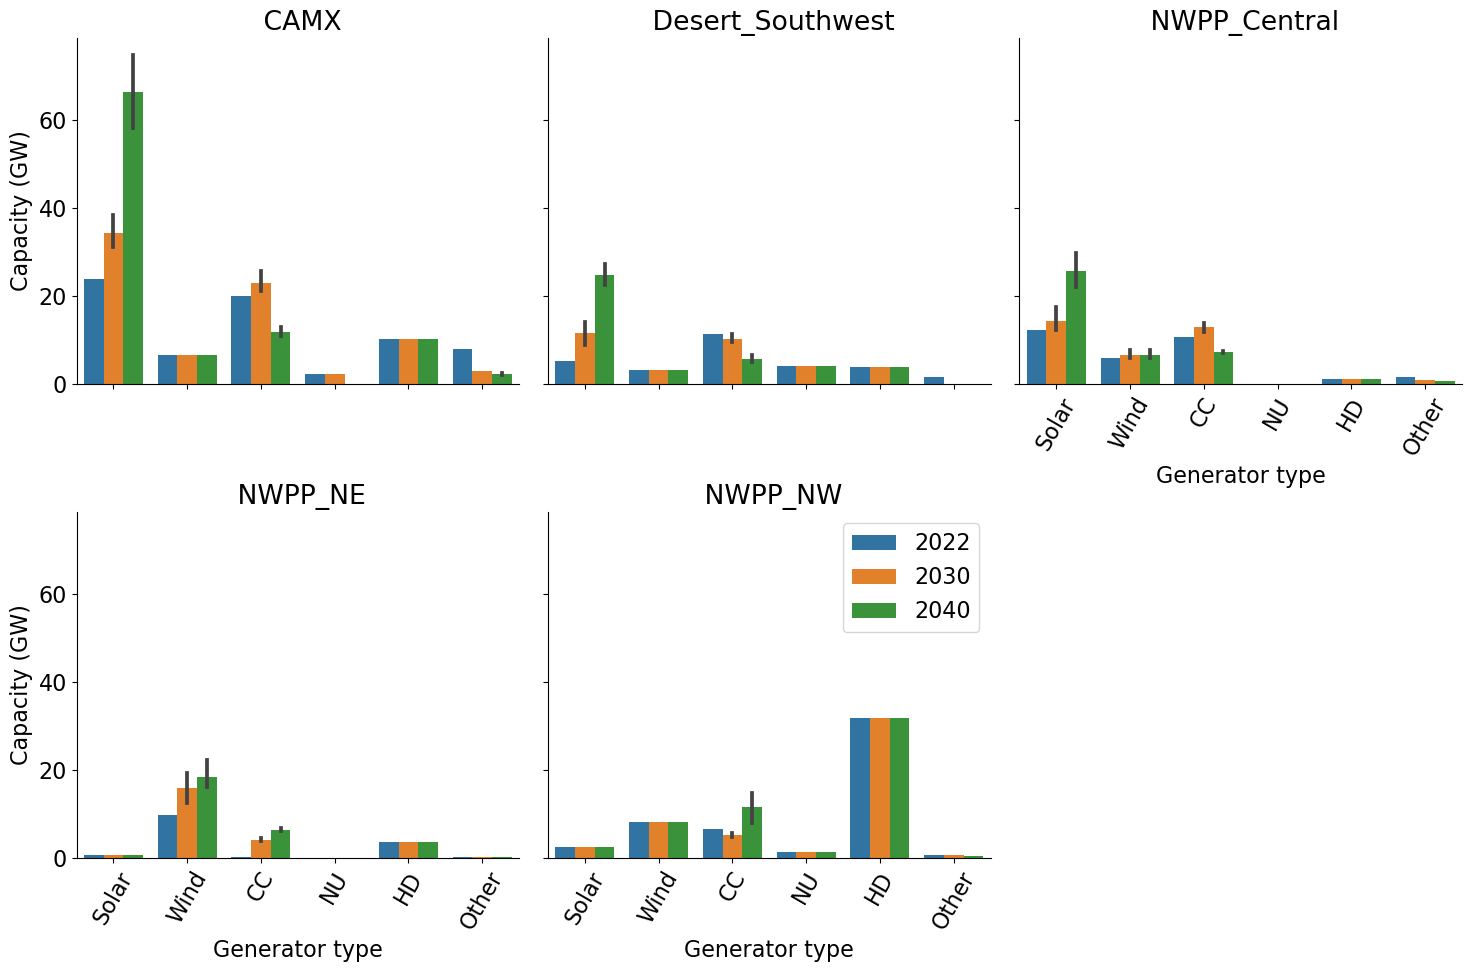

In [36]:
#print([transmission_dict[key] for key in ['2022','2030','2040']])
from matplotlib.ticker import FuncFormatter

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['font.size']= 16

g = sns.catplot(data=gentype_across_ens_df_subregion,kind='bar',
            x='PlantType',y='Capacity (MW)',hue='time',
            col='region',col_wrap=3,
            order=['Solar','Wind','CC','NU','HD','Other'],
            sharey=True,sharex=True,legend=False,
               )

for idx,axes in enumerate(g.axes.flat):
    #print(axes.get_xticklabels())
    axes.tick_params(axis='x', rotation=60)
    axes.set_xlabel('Generator type')
    axes.set_ylabel('Capacity (GW)')
    #axes.set_ylim([0,130e3])
    axes.set_yticklabels(axes.get_yticks()/1000)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1e3)))
    name=axes.get_title()
    axes.set_title(name[8:])
#plt.suptitle(invest_ens)
plt.legend()
plt.tight_layout()
plt.show()

# Obtain costs for each fleet

## Fixed cost

In [82]:
p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

CO2_allfleets = pd.DataFrame()
ens_info = pd.read_csv('ensinfo.csv')

year_all=[str(yr) for yr in range(2024,2042,2)]

total_cost_all = dict()

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]
    
    if invest_ens == 'r19i1231p1f2':
        continue
    if pathway not in pathway_rename_dict.keys():
        continue
        
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens
    
    total_cost = 0
    
    for year in year_all:
        
        CE_fleet_path = os.path.join(base_dir,fleet_name,str(year),'CE')
        total_cost+=pd.read_csv(CE_fleet_path+'/vFixedcostannualCE'+str(year)+'.csv',index_col=0).sum().sum()*((2040-int(year)+2)//2)
    
    pd.Series(total_cost,index=['fixedCostThrough2040']).to_csv(results_dir+'fixedcost2040_pway'
                                                                +pathway+'_invens'+invest_ens+'_year'+year+'.csv')
    
    total_cost_all[fleet_name] = total_cost

## Operational cost

In [11]:
p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

CO2_allfleets = pd.DataFrame()
ens_info = pd.read_csv('ensinfo.csv')


opcost_all = dict()

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]
    
    #if invest_ens != 'r19i1231p1f2':
    #    continue
    if pathway not in pathway_rename_dict.keys():
        continue
        
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens

    all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)
    
    opcost_df = pd.DataFrame(index=ens_info['ensemble_forcing'])
    
    for year in range(2023,2041):
        if int(year)%2:
            fleet_year = str(int(year)+1)
        else:
            fleet_year = str(year)

        all_ens_nonREgen = pd.concat([pd.read_csv(results_dir+'nonRE_gen_pway'+pathway+'_invens'
                                                  +invest_ens+'_year'+str(year)+'_'+str(i)+'.csv',index_col=0)
                                      for i in range(10)],axis=1)

        fleet_year_ds = fleet_ds.sel(time=fleet_year)
        fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
        fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')

        fleet_year_df_nonRE = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['ST','CT','CC','CCCCS','NU','Other'])]
        fleet_year_df_nonRE = fleet_year_df_nonRE.loc[fleet_year_df_nonRE['Retired'].isin([False])]

        opcost = (all_ens_nonREgen.T.multiply(fleet_year_df_nonRE['OpCost($/MWh)']*24)).sum(axis=1)
        opcost.index.name = 'ensemble_forcing'
        opcost.name = str(year)
        
        opcost_df = pd.concat([opcost_df,opcost],axis=1)
        
    opcost_df.to_csv(results_dir+'opcost_all_pway'
                     +pathway+'_invens'+invest_ens+'.csv')

    opcost_all[fleet_name] = opcost_df

# Analyze time series of ENS

In [10]:
SAC_allfleets = xr.Dataset(coords={'time':np.empty(0,dtype='datetime64[ns]'),
                                   'reliability_ens':np.empty(0),
                                  }
                          )

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]


for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens == 'r19i1231p1f2':
        continue
    if pathway not in pathway_rename_dict.keys():
        continue
        
    SAC_fleet = xr.concat([xr.open_mfdataset([results_dir+'/SAC_pway'+pathway+'_invens'+invest_ens
                                             +'_year'+str(year)+'_'+str(i)+'.nc' for year in range(2023,2041)])
                           for i in range(10)],
                          dim='reliability_ens'
                         )
    SAC_fleet = SAC_fleet.expand_dims({#'pathway':[pathway],
                                       #'invest_ens':[invest_ens],
                                       'fleet':[pathway_rename_dict[pathway]+','+invest_ens[:-4]]
                                      })

    SAC_allfleets = xr.merge([SAC_allfleets,SAC_fleet])

SAC_allfleets['pathway'] = ('fleet',[val[:4] for val in SAC_allfleets.fleet.values])
SAC_allfleets['invest_ens'] = ('fleet',[val[5:] for val in SAC_allfleets.fleet.values])
SAC_allfleets = SAC_allfleets.set_coords(('pathway','invest_ens'))

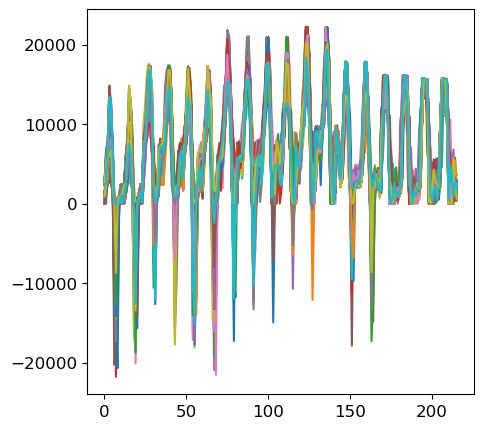

In [11]:
plt.plot(SAC_allfleets['CAMX'].isel(fleet=1).resample(time='1M').min().values)
#plt.title()
plt.show()

# Worst ensemble

# Dispatch

For different fleets, find how the flow, hydro, SAC look for same RA ensemble. RA ensemble can be when the difference between the fleets is highest, or both are 0, or something similar.

In [251]:
region = 'CAMX'
year = '2040'
pathway = '11RE0W0'
invest_ens_1 = 'r10i1191p1f2'
invest_ens_2 = 'r5i1231p1f1'

SACs_fleet = SAC_allfleets_yearmin.sel(time=year).sel(fleet=['10 %,'+invest_ens_1[:-4],
                                                             '10 %,'+invest_ens_2[:-4]])[region]

SACs_time = SAC_master.sel(time=year).sel(fleet=['10 %,'+invest_ens_1[:-4],
                                                  '10 %,'+invest_ens_2[:-4]])[region].idxmin('time')


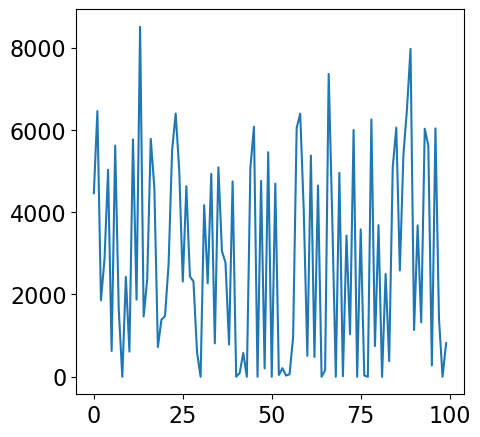

In [280]:
plt.plot(SAC_allfleets_yearmin.sel(time=year).sel(fleet=['50 %,'+invest_ens_2[:-4]])[region].values.flatten())

In [242]:
reqd_RAens = SACs_fleet.diff('fleet').compute().idxmax('reliability_ens').values[0,0]
reqd_RAens = ens_info.iloc[19]['ensemble_forcing']

In [243]:
reqd_RAens

'r10i1191p1f2'

In [244]:
results_dir_dispatch = '/glade/work/sriharis/paper2_SAC_data/06132023/'

In [245]:
partition_reqd = 2
hydro_invest_ens1 = xr.open_mfdataset(results_dir_dispatch+'hydro_gen_pway'+pathway+'_invens'+invest_ens_1
                                    +'_year'+year+'_'+'*.nc',combine='nested')[region].sel(reliability_ens=reqd_RAens)
hydro_invest_ens2 = xr.open_mfdataset(results_dir_dispatch+'hydro_gen_pway'+pathway+'_invens'+invest_ens_2
                                    +'_year'+year+'_'+'*.nc',combine='nested')[region].sel(reliability_ens=reqd_RAens)

flow_invest_ens1 = xr.open_mfdataset(results_dir_dispatch+'flow_gen_pway'+pathway+'_invens'+invest_ens_1
                                    +'_year'+year+'_'+'*.nc',combine='nested')[region].sel(reliability_ens=reqd_RAens)
flow_invest_ens2 = xr.open_mfdataset(results_dir_dispatch+'flow_gen_pway'+pathway+'_invens'+invest_ens_2
                                    +'_year'+year+'_'+'*.nc',combine='nested')[region].sel(reliability_ens=reqd_RAens)

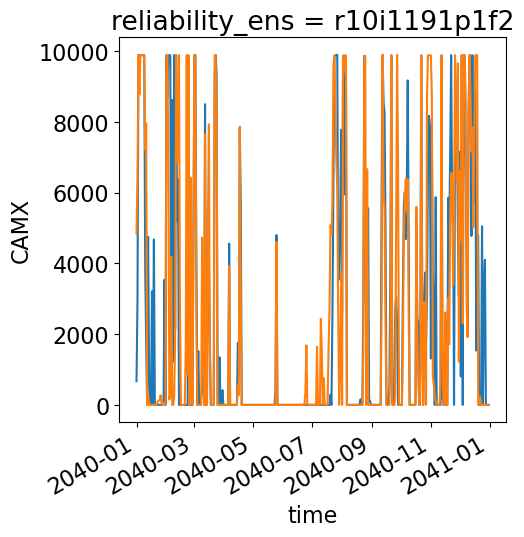

In [246]:
hydro_invest_ens1.plot()
hydro_invest_ens2.plot()

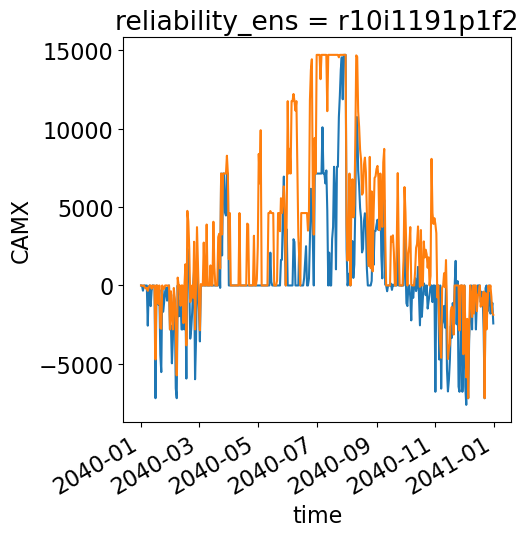

In [247]:
flow_invest_ens1.plot()
flow_invest_ens2.plot()

:NdOverlay   [fleet]
   :Curve   [time]   (CAMX)
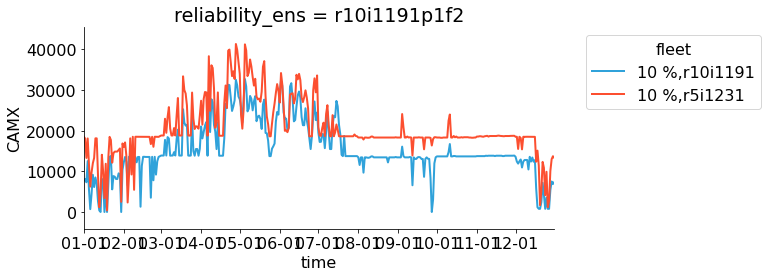

In [248]:
SAC_master.sel(time=year).sel(fleet=['10 %,'+invest_ens_1[:-4],
                                                  '10 %,'+invest_ens_2[:-4]]).sel(reliability_ens=reqd_RAens)[region].hvplot.line(x='time',by='fleet',xformatter=myFmt)

# Generate script to run all

## BE CAREFUL WHEN RUNNING THIS!

In [9]:
base_dir = '/glade/work/sriharis/MacroCEMResults/forpaper/'

p = pathlib.Path(base_dir)
subdirectories = [x.name for x in p.iterdir() if x.is_dir()]

outfile = open('SAC_run_list_'+datetime.today().strftime('%Y%m%d_%H:%M'),'w')

for subdir_name in subdirectories:
    pway_em = list(filter(None, re.split(r'WECCC|EM', subdir_name)))
    
    pathway = pway_em[0]
    invest_ens = pway_em[1]

    if invest_ens != 'r19i1231p1f2':
        continue
    if pathway not in pathway_rename_dict.keys():
        continue
        
    for year in range(2023,2041):
        for part in range(10):
            print("qsub -v RE_pway=\""+pathway+"\",INV_ENS=\""
                  +invest_ens+"\",YEAR=\""+str(year)+"\",PART=\""+str(part)
                  +"\" casper_pbs_SAC_calc.sh",
                  file=outfile
                 )
        
        
outfile.close()

# Obtain co2 cost
This was abandoned in favor of enforcing co2 emissions in the EDM

In [47]:
def get_co2_emissions(pathway,invest_ens,co2_cap,year='2040',return_fleet=False):
    
    if int(year)%2:
        fleet_year = str(int(year)+1)
    else:
        fleet_year = year
    
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens
    reliability_ens = invest_ens

    all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
    all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

    met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'

    demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
    solar_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_solar_CF.nc')
    wind_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_wind_CF_noBC.nc')
    FOR_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_FOR.nc')
    derate_ds = xr.open_dataset(met_inputs_source_dir+'cesm_derate_fields.nc')
    hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

    fleet_year_ds = fleet_ds.sel(time=fleet_year)
    fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
    fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')
    
    solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
    wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
    FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
    derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
    hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
                .groupby('region').sum().to_dataframe().reset_index(level=0)
    monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

    demand_year = demand_ds.sel(time=year)\
                                  .sel(member_id=reliability_ens)\
                                  .to_dataframe().reset_index(level=1)
    demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                        columns='region')
    
    fleet_year_df_nonRE = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['ST','CT','CC','CCCCS','NU','Other'])]
    fleet_year_df_nonRE = fleet_year_df_nonRE.loc[fleet_year_df_nonRE['Retired'].isin([False])]

    if return_fleet:
        return fleet_year_df_nonRE

    #flow,hydro,ens,RE_generation,nonRE_nonHD,nonRE_nonHD_generation_allregions,RE_generation_allregions,solar_allregions,wind_allregions,model = SAC.run_economicdispatch(all_regions,fleet_year_df,
    _,_,annual_nonRE_generation_df,_,_,_,_ = SAC.run_economicdispatch(all_regions,fleet_year_df,
                                compressed_units,demand_year,
                             solar_cf_year_ens,wind_cf_year_ens,
                             FOR_ds_year_ens,derate_ds_year_ens,
                             monthly_limits_total,
                             transmission_dict[fleet_year],
                             flow_cost=0.01,ens_cost=10000,
                             co2cost=None,co2_cap=co2_cap)
    
    co2_pway_ens = (annual_nonRE_generation_df\
                    *fleet_year_df_nonRE['CO2EmRate(lb/MMBtu)']\
                    *fleet_year_df_nonRE['Heat Rate (Btu/kWh)']/1000*24).sum()
    
    return co2_pway_ens,fleet_year_df_nonRE,annual_nonRE_generation_df


In [48]:
fleet_name = 'WECCC'+pathway+'EM'+invest_ens
reliability_ens = invest_ens

all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
compressed_units = SAC.rename_plant_types(compressed_units)
compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

In [49]:
co2_caps = pd.read_csv('co2_caps_fleets.txt',skiprows=1)
co2_caps['co2_emissions'] = co2_caps['co2_emissions']*2000/2

In [14]:
%time co2_emis,fleet_year_df_nonRE,_ = get_co2_emissions('20RE0W0','r12i1301p1f2',6.911544e+10)

CPU times: user 39.9 s, sys: 837 ms, total: 40.8 s
Wall time: 1min 5s


In [17]:
pway = '20RE0W0'
inv_ens = 'r12i1301p1f2'
print(inv_ens,co2_emis,
          ((co2_emis - co2_caps.set_index(['pathway','inv_ens']).loc[(pway,inv_ens)])*100\
           /co2_caps.set_index(['pathway','inv_ens']).loc[(pway,inv_ens)])
         )

r12i1301p1f2 69115440000.0049 co2_emissions    0.000001
Name: (20RE0W0, r12i1301p1f2), dtype: float64


In [50]:
pway = '80RE0W0'
for inv_ens in ['r10i1181p1f1','r10i1191p1f2', 'r12i1301p1f2', 'r5i1231p1f1', 'r9i1301p1f1']:
    %time co2_emis,fleet_year_df_nonRE,annual_nonRE_gen = get_co2_emissions(pway,inv_ens,co2_caps.set_index(['pathway','inv_ens']).loc[(pway,inv_ens)].values[0])

    annual_nonRE_gen.to_csv('nonRE_yearlytotal_'
                                      +inv_ens[:-4]+'_'+pway[:2]
                                      +'perc_'+'2040'+'.csv')
    print(inv_ens,co2_emis,
          ((co2_emis - co2_caps.set_index(['pathway','inv_ens']).loc[(pway,inv_ens)])*100\
           /co2_caps.set_index(['pathway','inv_ens']).loc[(pway,inv_ens)])
         )


CPU times: user 38.8 s, sys: 734 ms, total: 39.6 s
Wall time: 1min 32s
r10i1181p1f1 271914580140.3279 co2_emissions   -1.644776
Name: (80RE0W0, r10i1181p1f1), dtype: float64
CPU times: user 38.8 s, sys: 723 ms, total: 39.6 s
Wall time: 1min 46s
r10i1191p1f2 276110778075.3748 co2_emissions   -0.126954
Name: (80RE0W0, r10i1191p1f2), dtype: float64
CPU times: user 38.4 s, sys: 787 ms, total: 39.2 s
Wall time: 1min 27s
r12i1301p1f2 276461756799.995 co2_emissions   -1.810335e-12
Name: (80RE0W0, r12i1301p1f2), dtype: float64
CPU times: user 39.8 s, sys: 779 ms, total: 40.6 s
Wall time: 1min 52s
r5i1231p1f1 276214737341.6752 co2_emissions   -0.08935
Name: (80RE0W0, r5i1231p1f1), dtype: float64
CPU times: user 38.8 s, sys: 734 ms, total: 39.5 s
Wall time: 1min 31s
r9i1301p1f1 271678126539.52304 co2_emissions   -1.730305
Name: (80RE0W0, r9i1301p1f1), dtype: float64


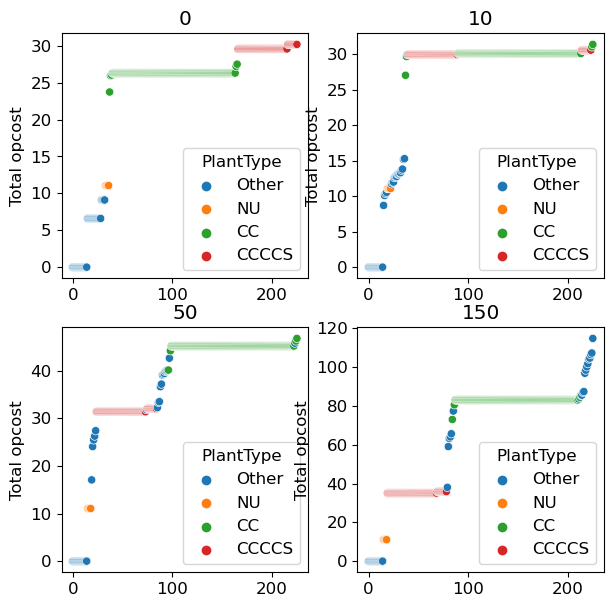

In [12]:
fig,ax = plt.subplots(2,2,figsize=(7,7))

fleet_year_df_nonRE = get_co2_emissions('20RE0W0','r5i1231p1f1',150,return_fleet=True)

for idx,co2_cost in enumerate([0,10,50,150]):
    fleet_year_df_nonRE['Total opcost'] = fleet_year_df_nonRE['OpCost($/MWh)']\
                                         +(fleet_year_df_nonRE['CO2EmRate(lb/MMBtu)']\
                                           *fleet_year_df_nonRE['Heat Rate (Btu/kWh)']/1000\
                                           *(co2_cost/2000)) #convert $/US ton to $/lb

    df = fleet_year_df_nonRE.sort_values('Total opcost').reset_index()
    sns.scatterplot(ax=ax[idx//2,idx%2],
                    data=df,
                    y='Total opcost',
                    x=df.index,
                    hue='PlantType',
                    hue_order=['Other','NU','CC','CCCCS']).set(title=str(co2_cost))
    
plt.show()

In [131]:
fleet_year_df_nonRE = get_co2_emissions('40RE0W0','r5i1231p1f1',co2_cost,return_fleet=True)

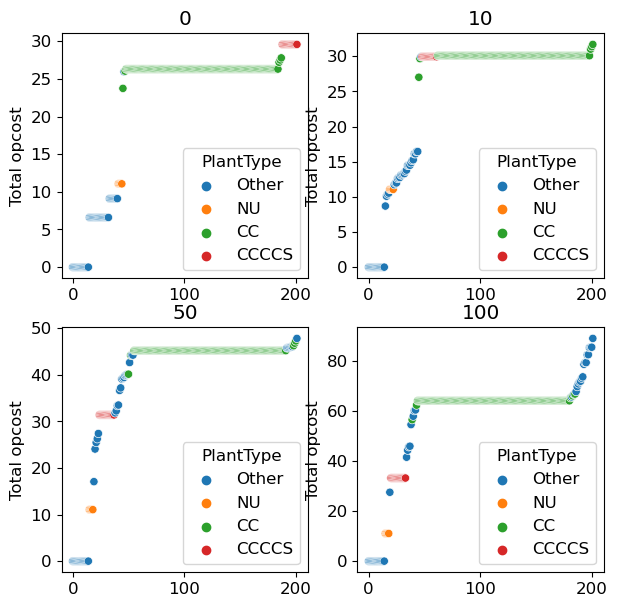

In [132]:
fig,ax = plt.subplots(2,2,figsize=(7,7))

for idx,co2_cost in enumerate([0,10,50,100]):
    fleet_year_df_nonRE['Total opcost'] = fleet_year_df_nonRE['OpCost($/MWh)']\
                                         +(fleet_year_df_nonRE['CO2EmRate(lb/MMBtu)']\
                                           *fleet_year_df_nonRE['Heat Rate (Btu/kWh)']/1000\
                                           *(co2_cost/2000)) #convert $/US ton to $/lb

    df = fleet_year_df_nonRE.sort_values('Total opcost').reset_index()
    sns.scatterplot(ax=ax[idx//2,idx%2],
                    data=df,
                    y='Total opcost',
                    x=df.index,
                    hue='PlantType',
                    hue_order=['Other','NU','CC','CCCCS']).set(title=str(co2_cost))
    
plt.show()

# Get generations for the different fleets

In [81]:
def get_generation_demand(reliability_ens):
    
    solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
    wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
    FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
    derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
    hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
                .groupby('region').sum().to_dataframe().reset_index(level=0)
    monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

    demand_year = demand_ds.sel(time=year)\
                                  .sel(member_id=reliability_ens)\
                                  .to_dataframe().reset_index(level=1)
    demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                        columns='region')


    solar_year,wind_year=SAC.run_economicdispatch(all_regions,fleet_year_df,
                                                 compressed_units,demand_year,
                                                 solar_cf_year_ens,wind_cf_year_ens,
                                                 FOR_ds_year_ens,derate_ds_year_ens,
                                                 monthly_limits_total,
                                                 transmission_dict[fleet_year],
                                                 flow_cost=0.01,ens_cost=10000,
                                                 return_generations_damand=True)

    solar_year.index.name = 'time'
    solar_year['reliability_ens'] = np.repeat(reliability_ens,len(solar_year.index))
    solar_year = solar_year.reset_index()
    solar_year.set_index(['time','reliability_ens'],inplace=True)

    wind_year.index.name = 'time'
    wind_year['reliability_ens'] = np.repeat(reliability_ens,len(wind_year.index))
    wind_year = wind_year.reset_index()
    wind_year.set_index(['time','reliability_ens'],inplace=True)
    
    return solar_year.to_xarray(),wind_year.to_xarray()



# Test economic dispatch

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size']= 14

In [9]:
import importlib
import economicdispatch as ed
import SAC as SAC
import CalculateDerates as calc_derates
importlib.reload(calc_derates)
importlib.reload(ed)
importlib.reload(SAC)

<module 'SAC' from '/glade/u/home/sriharis/RDM_analysis/SAC.py'>

In [10]:
all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

ens_info = pd.read_csv('ensinfo.csv')

pathway = '11RE0W0'
invest_ens = 'r5i1231p1f1'
fleet_name = 'WECCC'+pathway+'EM'+invest_ens

compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
compressed_units = SAC.rename_plant_types(compressed_units)
compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'

demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
solar_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_solar_CF.nc')
wind_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_wind_CF_noBC.nc')
FOR_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_FOR.nc')
derate_ds = xr.open_dataset(met_inputs_source_dir+'cesm_derate_fields.nc')
hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

#year = '2024'
reliability_ens = ens_info['ensemble_forcing'].iloc[20]
#year=slice('2029','2030')
year='2040'
if int(year)%2:
    fleet_year = str(int(year)+1)
else:
    fleet_year = year
    
solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
            .groupby('region').sum().to_dataframe().reset_index(level=0)
monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

demand_year = demand_ds.sel(time=year)\
                              .sel(member_id=reliability_ens)\
                              .to_dataframe().reset_index(level=1)
demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                    columns='region')

fleet_year_ds = fleet_ds.sel(time=fleet_year)
fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')


SAC_df,ens_df,annual_nonRE_generation_df,hydro_df,flow_df,nonRE_nonHD_generation_regionaltotals,RE_generation_allregions,nonRE_CFs,nonRE_nonHD_generation_allregions  = SAC.run_economicdispatch(all_regions,fleet_year_df,
                            compressed_units,demand_year,
                         solar_cf_year_ens,wind_cf_year_ens,
                         FOR_ds_year_ens,derate_ds_year_ens,
                         monthly_limits_total,
                         transmission_dict[fleet_year],
                         flow_cost=0.01,ens_cost=10000,
                         return_everything=True)

In [12]:
flow_all = (-1*flow_df['CAMX']).to_numpy()
flow_positive = np.where(flow_all>0,flow_all,0)
flow_negative = np.where(flow_all<0,flow_all,0)

In [ ]:
rcParams.update({'font.size': 12})
plt.stackplot(RE_generation_allregions.index,
              flow_positive/1e3,
              RE_generation_allregions['CAMX'].to_numpy()/1e3,
              hydro_df['CAMX'].to_numpy()/1e3,
              nonRE_nonHD_generation_regionaltotals['CAMX'].to_numpy()/1e3,              
              labels=['Transmission in','RE generation','Hydro','Non RE, non Hydro']
             )
plt.stackplot(RE_generation_allregions.index,
              flow_negative/1e3,
              -1*demand_year['CAMX'].to_numpy()/1e3,labels=['Transmission out','Demand'])
plt.plot(SAC_df['CAMX']/1e3,label='Surplus available capacity',linewidth=2.0)
plt.title('CAMX, daily surplus available capacity')
plt.xlabel('Time')
plt.ylabel('Energy (GW)')
plt.legend(fontsize=10,ncol=2,bbox_to_anchor=(1.25,0.2))
plt.tick_params(axis='x', rotation=60)
plt.show()
rcParams.update({'font.size': 14})

# Get RE level

In [111]:
base_dir = '/glade/work/sriharis/MacroCEMResults/HariPaper2/'


all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

ens_info = pd.read_csv('ensinfo.csv')

import importlib
importlib.reload(SAC)

pathway = '20'
invest_ens = 'r10i1181p1f1'
fleet_name = 'ResultsWECCC'+pathway+'RE0PRM13EM'+invest_ens

compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
fleet_ds = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions,
                                                    year_all=['2022'],return_transmission=False)

met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'

demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
solar_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_solar_CF.nc')
wind_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_wind_CF.nc')
FOR_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_FOR.nc')
derate_ds = xr.open_dataset(met_inputs_source_dir+'cesm_derate_fields.nc')
hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

year = '2022'

for reliability_ens in ['r9i1301p1f1', 'r10i1181p1f1', 'r5i1231p1f1', 'r12i1301p1f2', 'r10i1191p1f2']:

    # Demand
    demand_year = demand_ds.sel(time=year)\
                                  .sel(member_id=reliability_ens)\
                                  .to_dataframe().reset_index(level=1)
    demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                        columns='region')[all_regions].sum(axis=1)

    fleet_year_ds = fleet_ds.sel(time=year)\
                    .where(fleet_ds['Capacity (MW)'].notnull(),drop=True)
    fleet_year = fleet_year_ds.to_dataframe().reset_index()

    fleet_RE = fleet_year.loc[fleet_year['PlantType'].isin(['Solar','Wind'])]

    solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
    wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)

    # Get solar and wind generation in region, year
    solar_df = SAC.calc_generation_RE(solar_cf_year_ens,
                                  fleet_RE.loc[fleet_RE['PlantType'].isin(['Solar'])],
                                  'Solar_CF')

    wind_df = SAC.calc_generation_RE(wind_cf_year_ens,
                                 fleet_RE.loc[fleet_RE['PlantType'].isin(['Wind'])],
                                 'Wind_CF')
    
    #print(reliability_ens,':','%0.2f'%((solar_df+wind_df).sum()*100/demand_year.sum())+'% RE')    
    print(reliability_ens,':','%0.2f'%((wind_df).sum()*100/demand_year.sum())+'% Wind')

r9i1301p1f1 : 2.00% Wind
r10i1181p1f1 : 1.89% Wind
r5i1231p1f1 : 1.97% Wind
r12i1301p1f2 : 2.12% Wind
r10i1191p1f2 : 2.17% Wind


# Modify fleets to get negative SAC

In [9]:
def run_SAC(pathway,invest_ens,co2_cap,year='2040',return_fleet=False):
    
    if int(year)%2:
        fleet_year = str(int(year)+1)
    else:
        fleet_year = year
    
    fleet_name = 'WECCC'+pathway+'EM'+invest_ens
    reliability_ens = invest_ens

    all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
    all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

    compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
    compressed_units = SAC.rename_plant_types(compressed_units)
    compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

    fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

    met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'

    demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
    solar_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_solar_CF.nc')
    wind_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_wind_CF_noBC.nc')
    FOR_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_FOR.nc')
    derate_ds = xr.open_dataset(met_inputs_source_dir+'cesm_derate_fields.nc')
    hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

    fleet_year_ds = fleet_ds.sel(time=fleet_year)
    fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
    fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')
    
    solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
    wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
    FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
    derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
    hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
                .groupby('region').sum().to_dataframe().reset_index(level=0)
    monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

    demand_year = demand_ds.sel(time=year)\
                                  .sel(member_id=reliability_ens)\
                                  .to_dataframe().reset_index(level=1)
    demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                        columns='region')
    
    fleet_year_df_nonRE = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['ST','CT','CC','CCCCS','NU','Other'])]
    fleet_year_df_nonRE = fleet_year_df_nonRE.loc[fleet_year_df_nonRE['Retired'].isin([False])]

    if return_fleet:
        return fleet_year_df_nonRE

    #flow,hydro,ens,RE_generation,nonRE_nonHD,nonRE_nonHD_generation_allregions,RE_generation_allregions,solar_allregions,wind_allregions,model = SAC.run_economicdispatch(all_regions,fleet_year_df,
    SAC_df,_,annual_nonRE_generation_df,_,_,_,_ = SAC.run_economicdispatch(all_regions,fleet_year_df,
                                compressed_units,demand_year,
                             solar_cf_year_ens,wind_cf_year_ens,
                             FOR_ds_year_ens,derate_ds_year_ens,
                             monthly_limits_total,
                             transmission_dict[fleet_year],
                             flow_cost=0.01,ens_cost=10000,
                             co2_cap=co2_cap)
    
    SAC_df.index.name = 'time'
    SAC_df['reliability_ens'] = np.repeat(reliability_ens,len(SAC_df.index))
    SAC_df = SAC_df.reset_index()
    SAC_df.set_index(['time','reliability_ens'],inplace=True)
    
    return SAC_df


In [11]:
co2_caps = pd.read_csv('co2_caps_fleets.txt',skiprows=1)
co2_caps['co2_emissions'] = co2_caps['co2_emissions']*2000/2

In [10]:
%time SAC_df = run_SAC('20RE0W0','r12i1301p1f2',6.911544e+10)

CPU times: user 44.8 s, sys: 1.27 s, total: 46 s
Wall time: 1min 16s


In [126]:
import importlib
importlib.reload(SAC)

<module 'SAC' from '/glade/u/home/sriharis/RDM_analysis/SAC.py'>

In [11]:
pathway = '20RE0W0'
invest_ens = 'r12i1301p1f2'
year='2040'
del_region = 'CAMX'

if int(year)%2:
    fleet_year = str(int(year)+1)
else:
    fleet_year = year

fleet_name = 'WECCC'+pathway+'EM'+invest_ens
reliability_ens = invest_ens

all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

compressed_units = pd.read_csv(base_dir+fleet_name+'/compressedUnitsFromGenFleet.csv')
compressed_units = SAC.rename_plant_types(compressed_units)
compressed_units = compressed_units.rename(columns={"Latitude": "lat", "Longitude": "lon"})

fleet_ds,transmission_dict = SAC.get_reqdfleet_info(base_dir,fleet_name,all_regions)

met_inputs_source_dir = '/glade/work/sriharis/RDM_dsets/'

demand_ds = xr.open_dataset(met_inputs_source_dir+'demand_allmembers.nc')
solar_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_solar_CF.nc')
wind_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_wind_CF_noBC.nc')
FOR_ds = xr.open_dataset(met_inputs_source_dir+'cesm_WECC_FOR.nc')
derate_ds = xr.open_dataset(met_inputs_source_dir+'cesm_derate_fields.nc')
hydro_ds = xr.open_dataset(met_inputs_source_dir+'monthly_hydro_generation_plants.nc')

fleet_year_ds = fleet_ds.sel(time=fleet_year)
fleet_year_ds = fleet_year_ds.where(fleet_year_ds['Capacity (MW)'].notnull(),drop=True)
fleet_year_df = fleet_year_ds.to_dataframe().reset_index().set_index('GAMS Symbol')

fleet_year_df_nonRE = fleet_year_df.loc[fleet_year_df['PlantType'].isin(['ST','CT','CC','CCCCS','NU','Other'])]
fleet_year_df_nonRE = fleet_year_df_nonRE.loc[fleet_year_df_nonRE['Retired'].isin([False])]

In [12]:
co2_cap = 6.911544e+10
solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
            .groupby('region').sum().to_dataframe().reset_index(level=0)
monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

demand_year = demand_ds.sel(time=year)\
                              .sel(member_id=reliability_ens)\
                              .to_dataframe().reset_index(level=1)
demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                    columns='region')

SAC_df,ens_df,_,_,_,_,_ = SAC.run_economicdispatch(all_regions,fleet_year_df,
                                                    compressed_units,demand_year,
                                                    solar_cf_year_ens,wind_cf_year_ens,
                                                    FOR_ds_year_ens,derate_ds_year_ens,
                                                    monthly_limits_total,
                                                    transmission_dict[fleet_year],
                                                    flow_cost=0.01,ens_cost=10000,
                                                    co2_cap=co2_cap)

SAC_df.index.name = 'time'
SAC_df['reliability_ens'] = np.repeat(reliability_ens,len(SAC_df.index))
SAC_df = SAC_df.reset_index()
SAC_df.set_index(['time','reliability_ens'],inplace=True)

<AxesSubplot:xlabel='time,reliability_ens'>

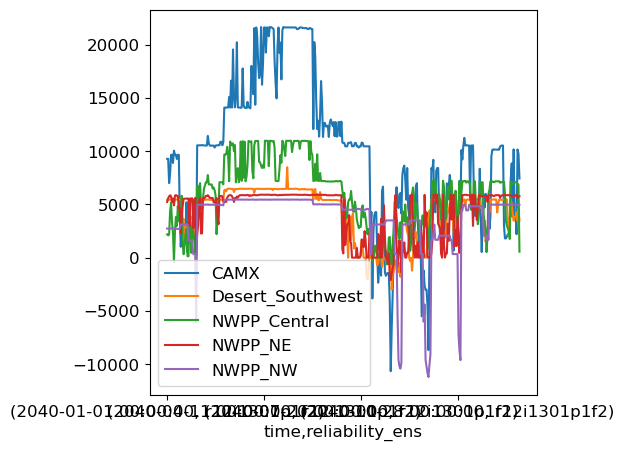

In [13]:
SAC_df.plot()

<AxesSubplot:xlabel='time'>

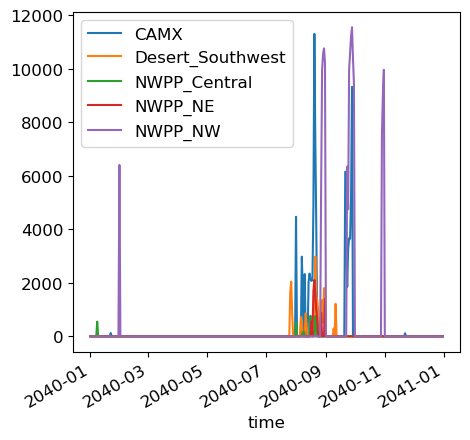

In [14]:
ens_df.plot()

In [18]:
reliability_ens = 'r5i1231p1f1'
co2_cap = 6.911544e+30
solar_cf_year_ens = solar_ds.sel(time=year).sel(member_id=reliability_ens)    
wind_cf_year_ens = wind_ds.sel(time=year).sel(member_id=reliability_ens)
FOR_ds_year_ens = FOR_ds.sel(time=year).sel(member_id=reliability_ens)
derate_ds_year_ens = derate_ds.sel(time=year).sel(member_id=reliability_ens)
hydro_df = hydro_ds.sel(time=year).sel(member_id=reliability_ens)\
            .groupby('region').sum().to_dataframe().reset_index(level=0)
monthly_limits_total = hydro_df.pivot_table(values='mon_hydro', index=hydro_df.index, columns='region')

demand_year = demand_ds.sel(time=year)\
                              .sel(member_id=reliability_ens)\
                              .to_dataframe().reset_index(level=1)
demand_year = demand_year.pivot_table(values='demand',index=demand_year.index, 
                                                    columns='region')

SAC_df,ens_df,_,_,_,_,_ = SAC.run_economicdispatch(all_regions,fleet_year_df,
                                                    compressed_units,demand_year,
                                                    solar_cf_year_ens,wind_cf_year_ens,
                                                    FOR_ds_year_ens,derate_ds_year_ens,
                                                    monthly_limits_total,
                                                    transmission_dict[fleet_year],
                                                    flow_cost=0.01,ens_cost=10000,
                                                    co2_cap=co2_cap)

SAC_df.index.name = 'time'
SAC_df['reliability_ens'] = np.repeat(reliability_ens,len(SAC_df.index))
SAC_df = SAC_df.reset_index()
SAC_df.set_index(['time','reliability_ens'],inplace=True)

<AxesSubplot:xlabel='time,reliability_ens'>

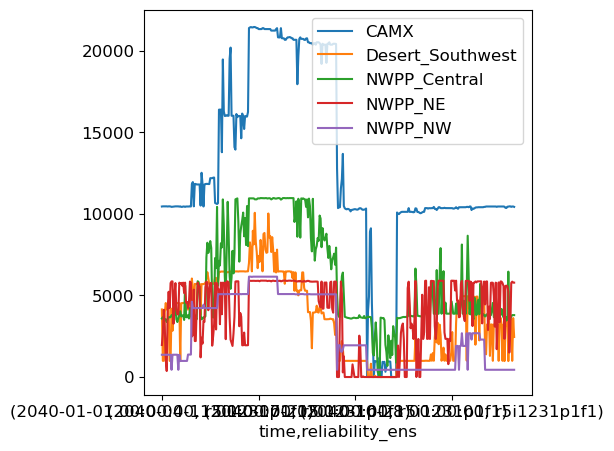

In [19]:
SAC_df.plot()

<AxesSubplot:xlabel='time'>

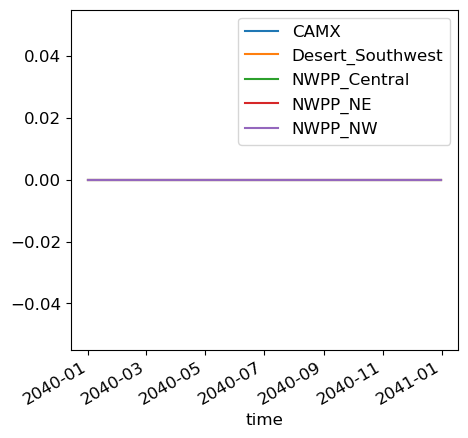

In [20]:
ens_df.plot()

In [ ]:
region_remove = 'CAMX'
region_SAC = 'CAMX'
while SAC_df[region_SAC].min() > -1e-3:
    # remove the plant with highest CO2 emissions per MWh
    
    fleet_year_df_nonRE['CO2emis_MWh (lb/MWh)'] = (fleet_year_df_nonRE['CO2EmRate(lb/MMBtu)']*\
                                               fleet_year_df_nonRE['Heat Rate (Btu/kWh)']/1e3)
    
    remove_idx = fleet_year_df_nonRE[fleet_year_df_nonRE['region'].isin([region_remove])
                                    ]['CO2emis_MWh (lb/MWh)'].idxmax()
    print(fleet_year_df.loc[remove_idx])
    
    fleet_year_df = fleet_year_df.drop(remove_idx)
    fleet_year_df_nonRE = fleet_year_df.loc[fleet_year_df['PlantType']\
                                            .isin(['ST','CT','CC','CCCCS','NU','Other'])]
    fleet_year_df_nonRE = fleet_year_df_nonRE.loc[fleet_year_df_nonRE['Retired'].isin([False])]

    SAC_df,_,_,_,_,_,_ = SAC.run_economicdispatch(all_regions,fleet_year_df,
                                                    compressed_units,demand_year,
                                                    solar_cf_year_ens,wind_cf_year_ens,
                                                    FOR_ds_year_ens,derate_ds_year_ens,
                                                    monthly_limits_total,
                                                    transmission_dict[fleet_year],
                                                    flow_cost=0.01,ens_cost=10000,
                                                    co2_cap=co2_cap)
    

    SAC_df.index.name = 'time'
    SAC_df['reliability_ens'] = np.repeat(reliability_ens,len(SAC_df.index))
    SAC_df = SAC_df.reset_index()
    SAC_df.set_index(['time','reliability_ens'],inplace=True)
    
    print(SAC_df.min(),SAC_df.idxmin())

<AxesSubplot:xlabel='time,reliability_ens'>

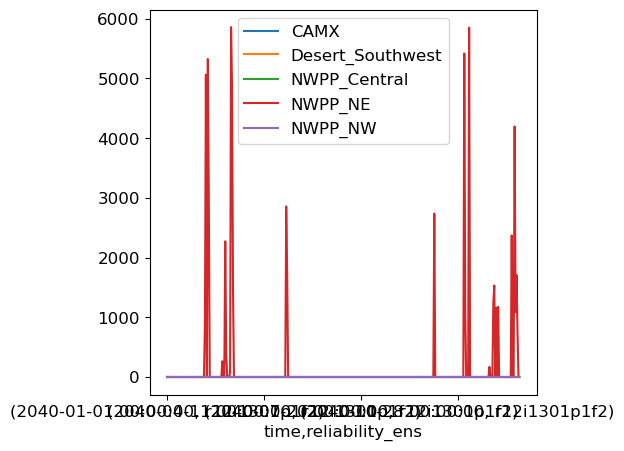

In [113]:
SAC_df.plot()

<AxesSubplot:xlabel='time'>

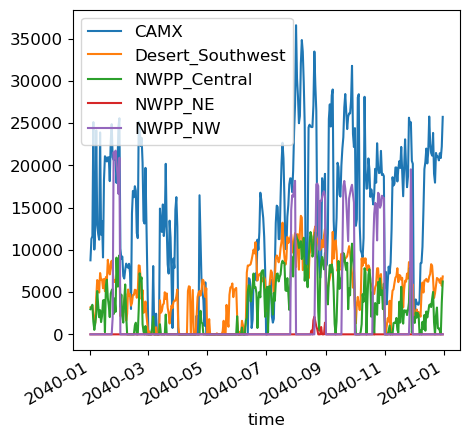

In [115]:
ens_df.plot()

In [73]:
fleet_year_df

time PlantType        lat         lon  \
GAMS Symbol                                                      
100+SC1            2040-01-01        HD  33.466477  248.218936   
10003+BLR1COMBINED 2040-01-01     Other  39.561991  253.665095   
10003+BLR5         2040-01-01     Other  39.760600  254.785000   
10005+WTGS         2040-01-01      Wind  37.047800  238.829200   
10014+U131         2040-01-01        HD  43.528000  243.941700   
...                       ...       ...        ...         ...   
925+3              2040-01-01        HD  39.205623  248.665619   
9842+20            2040-01-01        HD  48.675944  238.759174   
987+1              2040-01-01        HD  42.603349  248.294696   
987+2              2040-01-01        HD  42.603349  248.294696   
987+3              2040-01-01        HD  42.603349  248.294696   

                    Nameplate Energy Capacity (MWh)  Capacity (MW)  \
GAMS Symbol                                                          
100+SC1                                         NaN            1.4   
10003+BLR1COMBINED                              NaN           44.0   
10003+BLR5                                      NaN           10.0   
10005+WTGS                                      NaN           17.0   
10014+U131                                      NaN           36.2   
...                                             ...            ...   
925+3                                           NaN            2.0   
9842+20                                         NaN            2.3   
987+1                                           NaN            0.2   
987+2                                           NaN            0.4   
987+3                                           NaN            0.8   

                              region CoolingType  OpCost($/MWh)  Retired  \
GAMS Symbol                                                                
100+SC1             Desert_Southwest         NaN       0.000000      0.0   
10003+BLR1COMBINED      NWPP_Central         NaN      43.789380      1.0   
10003+BLR5              NWPP_Central         NaN      40.816639      1.0   
10005+WTGS                      CAMX         NaN       0.000000      0.0   
10014+U131                   NWPP_NW         NaN       0.000000      0.0   
...                              ...         ...            ...      ...   
925+3                   NWPP_Central         NaN       0.000000      0.0   
9842+20                      NWPP_NW         NaN       0.000000      0.0   
987+1                        NWPP_NE         NaN       0.000000      0.0   
987+2                        NWPP_NE         NaN       0.000000      0.0   
987+3                        NWPP_NE         NaN       0.000000      0.0   

                    CO2EmRate(lb/MMBtu)  Heat Rate (Btu/kWh)  
GAMS Symbol                                                   
100+SC1                             0.0             0.000000  
10003+BLR1COMBINED                117.0          9077.954545  
10003+BLR5                        117.0          8300.000000  
10005+WTGS                          0.0             0.000000  
10014+U131                          0.0             0.000000  
...                                 ...                  ...  
925+3                               0.0             0.000000  
9842+20                             0.0             0.000000  
987+1                               0.0             0.000000  
987+2                               0.0             0.000000  
987+3                               0.0             0.000000  

[4472 rows x 12 columns]

In [76]:
fleet_year_df.groupby(['PlantType','region']).sum()['Capacity (MW)']

PlantType  region          
CC         CAMX                18702.900000
           Desert_Southwest    11223.000000
           NWPP_Central        17794.968396
           NWPP_NE              6155.578651
           NWPP_NW              6566.200000
CCCCS      NWPP_Central         3852.407016
CT         CAMX                11693.400000
           Desert_Southwest     4097.800000
           NWPP_Central         5356.300000
           NWPP_NE               468.200000
           NWPP_NW              2053.300000
HD         CAMX                10177.100000
           Desert_Southwest     3840.200000
           NWPP_Central          965.500000
           NWPP_NE              3504.100000
           NWPP_NW             31785.800000
NU         CAMX                 2240.000000
Other      CAMX                 5809.300000
           Desert_Southwest     1619.100000
           NWPP_Central         1450.700000
           NWPP_NE                29.800000
           NWPP_NW               151.700000
ST  

In [78]:
fleet_year_df.groupby(['PlantType','region']).sum()['Capacity (MW)']

PlantType  region          
CC         CAMX                30155.678633
           Desert_Southwest    16841.739817
           NWPP_Central        17794.968396
           NWPP_NE              6155.578651
           NWPP_NW             11327.996160
CCCCS      CAMX                10495.402611
           Desert_Southwest     1027.289996
           NWPP_Central         3852.407016
           NWPP_NW               455.308257
CT         CAMX                11693.400000
           Desert_Southwest     4097.800000
           NWPP_Central         5356.300000
           NWPP_NE               468.200000
           NWPP_NW              2053.300000
HD         CAMX                10177.100000
           Desert_Southwest     3840.200000
           NWPP_Central          965.500000
           NWPP_NE              3504.100000
           NWPP_NW             31785.800000
NU         CAMX                 2240.000000
           Desert_Southwest     3937.000000
           NWPP_NW              1163.000000
Othe

In [69]:
pathway

'20RE0W0'

In [70]:
reliability_ens

'r12i1301p1f2'

# RAM

In [7]:
import RAM as RAM

In [8]:
import importlib
importlib.reload(RAM)

<module 'RAM' from '/glade/u/home/sriharis/RDM_analysis/RAM.py'>

In [13]:
pway = '20RE0W0'
inv_ens = 'r12i1301p1f2'

fleet_name = 'WECCC'+pway+'EM'+inv_ens
reliability_ens = inv_ens

all_gens = ['NU','HD','ST','CT','CC','CCCCS','Solar','Wind','Storage','Other']
all_regions = ['CAMX', 'Desert_Southwest', 'NWPP_Central', 'NWPP_NE', 'NWPP_NW']

fleet_ds,transmission_dict = RAM.get_reqdfleet_info(base_dir,fleet_name,all_regions)

In [ ]:
#SAC_master = actual_SAC
SAC_allfleets_yearmin = SAC_master.resample(time='1Y').min()
fig,ax = plt.subplots(3,2,figsize=(11,12))

SAC_min_sumregions_df = SAC_allfleets_yearmin.sel(time='2040').to_dataframe().sum(axis=1)

for idx,region in enumerate(['CAMX','Desert_Southwest','NWPP_NW']):

    ########
    for idx_yr,year in enumerate(['2030','2040']):
        d = SAC_allfleets_yearmin.sel(time=year)[region]
        #d = SAC_allfleets.sel(time=slice(year+'-06',year+'-09')).min('time')[region]
        SAC_np = d.values.reshape(len(SAC_master.fleet),len(ens_info))
        lim_val = np.max(np.abs(SAC_np))
        
        if region == 'CAMX' and year == '2040':
            unique, counts = np.unique(SAC_np[0:5,:].sum(axis=0).argmin(), return_counts=True)
            print(np.asarray((unique, counts)).T)
            #print(SAC_np.argmin(axis=1))

        im = ax[idx,idx_yr].imshow(SAC_np/1e3,aspect=100/len(SAC_master.fleet),
                   cmap=cmap_SAC,
                   vmin=-1*lim_val/1e3,vmax=lim_val/1e3
                  )
        # Minor ticks
        ax[idx,idx_yr].set_yticks(np.arange(-.5, 5*len(pathway_rename_dict), 5), minor=True)
        ax[idx,idx_yr].grid(which='minor', axis='y',color='k', linestyle='-', linewidth=2)
        ax[idx,idx_yr].tick_params(which='minor', bottom=False, left=False)
        

        if idx!=0:
            ax[idx,idx_yr].set_xticks(ticks=np.arange(0, 101, 5),labels=[])
            ax[idx,idx_yr].xaxis.tick_top()
            ax[idx,idx_yr].set_title(region+', '+year,y=1.05)
        else:
            ax[idx,idx_yr].set_title(region+', '+year)

        cbar = fig.colorbar(im,ax=ax[idx,idx_yr],label='Minimum annual SAC (GWh)',fraction=0.04, pad=0.05,location='right',
                           #format=lambda x, _: int(x/1e3)
                           )        


    ax[idx,0].set_ylabel('Decarbonization pathway')
    ax[idx,0].set_yticks(ticks=range(len(d['fleet'].values)),
               labels=y_labels,fontsize=12
              )

    ax[idx,1].set_yticks(ticks=range(len(d['fleet'].values)),labels=[]) 
    
ax[0,0].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,0].set_xlabel('Ensemble member')
ax[0,0].xaxis.set_label_position('top') 
ax[0,0].xaxis.tick_top() 

ax[0,1].set_xticks(ticks=[0,20,40,60,80,100])
ax[0,1].set_xlabel('Ensemble member')
ax[0,1].xaxis.set_label_position('top') 
ax[0,1].xaxis.tick_top() 

plt.tight_layout()
#plt.savefig('figures/SAC_3regions_allfleets.png')#, bbox_inches='tight')
plt.show()